In [1]:
!pip install dalex
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042471 sha256=b93ba3150ac3712286c65500580573c84c3d11289e824ba41845879fb6249c69
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb

from sklearn.metrics import f1_score, classification_report
import scikitplot as skplt
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

import dalex as dx

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Dibimbing/Homework   Projects/User Interview Project/User Interview 2/Dataset/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Dibimbing/Homework   Projects/User Interview Project/User Interview 2/Dataset/test.csv')

pd.set_option('display.max_columns', None)

In [5]:
df_train.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,0.0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314.0,NaN,0,Transient,38.4,0,0,Check-Out,2019-01-14,1
1,"Greensboro Courtyard Greensboro, NC",1,524,2018,December,51,15,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1.0,NaN,0,Transient,62.8,0,0,Canceled,2017-10-21,2


Observation:
- `is_canceled` is basically the same with `reservation_status`, where `0 = Check-Out` and `1 = Cancelled`

In [6]:
df_test.head(2)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
0,Fort Worth University Drive Courtyard Fort Wor...,46,2019,July,27,3,1,0,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,79.0,NaN,0,Transient,89.38,0,0,Canceled,2019-05-31,83293
1,Sacramento Airport Natomas Courtyard Sacrament...,98,2017,November,48,23,1,2,1,0.0,0,BB,FRA,Groups,TA/TO,0,0,0,A,D,0,No Deposit,37.0,NaN,0,Transient-Party,70.00,0,0,Check-Out,2017-11-26,83294


Observation:
- The `df_test` dataset has no `is_canceled` column like `df_train`. So we may need to create `is_canceled` on the `df_test` dataset based on `reservation_status`.
- Further, we may want to remove `reservation_status` and only use `is_canceled` instead. Because basically they both are the same.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83293 entries, 0 to 83292
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           83293 non-null  object 
 1   is_canceled                     83293 non-null  int64  
 2   lead_time                       83293 non-null  int64  
 3   arrival_date_year               83293 non-null  int64  
 4   arrival_date_month              83293 non-null  object 
 5   arrival_date_week_number        83293 non-null  int64  
 6   arrival_date_day_of_month       83293 non-null  int64  
 7   stays_in_weekend_nights         83293 non-null  int64  
 8   stays_in_week_nights            83293 non-null  int64  
 9   adults                          83293 non-null  int64  
 10  children                        83290 non-null  float64
 11  babies                          83293 non-null  int64  
 12  meal                            

Observations:
- `children`, `agent`, `company`, `country` has missing values
- `children`, and `agent` needs to be converted to int
- `reservation_status_date` needs to be converted to datetime

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35698 entries, 0 to 35697
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           35698 non-null  object 
 1   lead_time                       35698 non-null  int64  
 2   arrival_date_year               35698 non-null  int64  
 3   arrival_date_month              35698 non-null  object 
 4   arrival_date_week_number        35698 non-null  int64  
 5   arrival_date_day_of_month       35698 non-null  int64  
 6   stays_in_weekend_nights         35698 non-null  int64  
 7   stays_in_week_nights            35698 non-null  int64  
 8   adults                          35698 non-null  int64  
 9   children                        35697 non-null  float64
 10  babies                          35698 non-null  int64  
 11  meal                            35698 non-null  object 
 12  country                         

Observations:
- `children`, `agent`, `company`, `country` has missing values
- `children`, and `agent` needs to be converted to int
- `reservation_status_date` needs to be converted to datetime

In [9]:
df_train_backup = df_train.copy()
df_test_backup = df_test.copy()

#df_train = df_train.drop(columns=['bookingID'])
#df_test = df_test.drop(columns=['bookingID'])

# Categorical & Numerical Differentiate

In [10]:
df_train.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,0.0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314.0,NaN,0,Transient,38.4,0,0,Check-Out,2019-01-14,1
1,"Greensboro Courtyard Greensboro, NC",1,524,2018,December,51,15,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1.0,NaN,0,Transient,62.8,0,0,Canceled,2017-10-21,2


In [11]:
unique_values = df_train.apply(lambda x: x.unique())
print(unique_values)

hotel                             [Crystal Cove, Barbados Barbados, Greensboro C...
is_canceled                                                                  [0, 1]
lead_time                         [8, 524, 175, 0, 33, 395, 205, 52, 44, 167, 18...
arrival_date_year                                                [2019, 2018, 2017]
arrival_date_month                [January, December, May, October, September, M...
arrival_date_week_number          [2, 51, 20, 43, 39, 13, 24, 29, 40, 31, 30, 8,...
arrival_date_day_of_month         [10, 15, 19, 17, 26, 21, 13, 12, 3, 29, 27, 24...
stays_in_weekend_nights           [0, 1, 2, 4, 3, 6, 5, 8, 9, 19, 12, 10, 7, 18,...
stays_in_week_nights              [4, 2, 0, 3, 6, 1, 5, 10, 7, 8, 19, 9, 11, 14,...
adults                            [2, 1, 3, 0, 4, 50, 10, 26, 27, 40, 55, 5, 6, 20]
children                                            [0.0, 1.0, 2.0, 3.0, nan, 10.0]
babies                                                             [0, 1, 2,

In [12]:
lister = ['hotel', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month',
          'country', 'market_segment', 'agent', 'company']

for i in lister:
  print(f'{i}:', df_train[i].unique(), '\n')

hotel: ['Crystal Cove, Barbados Barbados' 'Greensboro Courtyard Greensboro, NC'
 'The Westin Peachtree Plaza, Atlanta Atlanta, GA '
 'Courtyard by Marriott Aberdeen Airport Aberdeen, United Kingdom'
 'W New York – Union Square New York, NY'
 'Hotel Maria Cristina, San Sebastian San Sebastian, Spain'
 'W New York – Times Square New York, NY'
 'The Ritz-Carlton, Tokyo Tokyo, Japan'
 'Marriott Puerto Vallarta Resort & Spa Puerto Vallarta, Mexico'
 'Las Vegas Marriott Las Vegas, NV '
 'Heidelberg Marriott Hotel Heidelberg, Germany'
 'Sheraton Grand Rio Hotel & Resort Rio de Janeiro, Brazil'
 'Renaissance Hamburg Hotel Hamburg, Germany'
 'The Ritz-Carlton, Berlin Berlin, Germany'
 'Sheraton Lima Hotel & Convention Center Lima, Peru'
 'Courtyard Las Vegas Convention Center Las Vegas, NV '
 'Newark Liberty International Airport Courtyard Newark, NJ'
 'Indianapolis Airport Courtyard Indianapolis, IN'
 'Treasure Beach, Barbados Barbados'
 'Cape Town Marriott Hotel Crystal Towers Cape Town, Sout

In [13]:
categorical = ['hotel', 'is_canceled', 'arrival_date_year', 'arrival_date_month',
               'arrival_date_week_number', 'arrival_date_day_of_month', 'meal',
               'country', 'market_segment', 'distribution_channel', 'is_repeated_guest',
               'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type',
               'agent', 'company', 'reservation_status']

# Missing Value

## Check

### Check for df_train

In [14]:
missing_val_train = df_train.isna().sum()
missing_val_train = missing_val_train[missing_val_train > 0]
missing_val_train

children        3
country       346
agent       11404
company     78559
dtype: int64

In [15]:
missing_pct_train = df_train.isnull().sum() * 100 / len(df_train)
missing_pct_train = missing_pct_train[missing_pct_train > 0]
pd.DataFrame({'Missing value percentage': missing_pct_train})

,Missing value percentage
children,0.003602
country,0.415401
agent,13.691427
company,94.316449


### Check for df_test

In [16]:
missing_val_test = df_test.isna().sum()
missing_val_test = missing_val_test[missing_val_test > 0]
missing_val_test

children        1
country       142
agent        4925
company     33636
dtype: int64

In [17]:
missing_pct_test = df_test.isnull().sum() * 100 / len(df_test)
missing_pct_test = missing_pct_test[missing_pct_test > 0]
pd.DataFrame({'Missing value percentage': missing_pct_test})

,Missing value percentage
children,0.002801
country,0.397781
agent,13.796291
company,94.223766


## Handling

### Handling for df_train

**Handling Kolom `company`**

Decision:

Drop `company` karena missing value melebihi 50% total data

In [18]:
threshold = 0.5 * len(df_train)
df_train.dropna(thresh=threshold, axis=1, inplace=True)

In [19]:
categorical.pop(categorical.index('company'))

'company'

**Handling Kolom `children`**

Decision:

Karena `children` hanya memiliki 3 missing value, kita akan imputasi menggunakan Median.

In [20]:
df_train['children'].fillna(df_train['children'].median(numeric_only=True), inplace=True)

**Handling Kolom `country`**

Kita harus cek terlebih dahulu, apakah memang ada negara yang mendominasi pada dataset. Jika ya, maka kita bisa secara aman imputasi berdasarkan Modus

In [21]:
country_counts = df_train['country'].value_counts().reset_index()
country_counts['percentage'] = (country_counts['count'] / df_train.shape[0]) * 100
print(country_counts)

    country  count  percentage
0       PRT  33952   40.762129
1       GBR   8381   10.062070
2       FRA   7243    8.695809
3       ESP   5897    7.079827
4       DEU   5107    6.131368
..      ...    ...         ...
160     MRT      1    0.001201
161     BRB      1    0.001201
162     NPL      1    0.001201
163     DJI      1    0.001201
164     NAM      1    0.001201

[165 rows x 3 columns]


Observations:

Karena PRT sudah mendominasi 40% dari keseluruhan kemunculan data pada `country`, maka kita memutuskan untuk mengimputasi dengan Modus.

In [22]:
df_train['country'].fillna(df_train['country'].mode()[0], inplace=True)

**Handling `agent`**

Karena jumlah missing value `agent` cukup banyak (mencapai 13%), maka agak bahaya jika kita melakukan imputasi, karena bisa mengotori data. Dan value yang kosong ini bisa jadi artinya adalah booking yang dilakukan tidak melalui `agent`.

Kita harus make sure dulu apakah ada nilai `0` pada kolom `agent` yang mungkin menandakan kalau `0` artinya adalah booking tanpa `agent`.

In [23]:
df_train[df_train['agent'] == 0].shape[0]

0

Ternyata value `agent` = 0 tidak ada. Bisa jadi memang artinya missing value ini merupakan bookingan tanpa melalui `agent`.

Maka kita akan isi dengan 0 untuk `agent` yang memiliki missing value.

In [24]:
df_train['agent'].fillna(0, inplace=True)

### Handling for df_test

**Handling Kolom `company`**

Decision:

Drop `company` karena missing value melebihi 50% total data

In [25]:
threshold = 0.5 * len(df_test)
df_test.dropna(thresh=threshold, axis=1, inplace=True)

**Handling Kolom `children`**

Decision:

Sama seperti `df_train`, karena `children` hanya memiliki 1 missing value di `df_test` ini, kita akan imputasi menggunakan Median.

In [26]:
df_test['children'].fillna(df_test['children'].median(numeric_only=True), inplace=True)

**Handling Kolom `country`**

Sama seperti pada `df_train`, kita harus cek terlebih dahulu, apakah memang ada negara yang mendominasi pada dataset. Jika ya, maka kita bisa secara aman imputasi berdasarkan Modus

In [27]:
country_counts_test = df_test['country'].value_counts().reset_index()
country_counts_test['percentage'] = (country_counts_test['count'] / df_test.shape[0]) * 100
print(country_counts_test)

    country  count  percentage
0       PRT  14366   40.243151
1       GBR   3735   10.462771
2       FRA   3164    8.863242
3       ESP   2599    7.280520
4       DEU   2172    6.084374
..      ...    ...         ...
138     MWI      1    0.002801
139     BWA      1    0.002801
140     CUB      1    0.002801
141     BHR      1    0.002801
142     NCL      1    0.002801

[143 rows x 3 columns]


Observations:

Karena PRT sudah mendominasi 40% dari keseluruhan kemunculan data pada `country`, maka kita memutuskan untuk mengimputasi dengan Modus.

In [28]:
df_test['country'].fillna(df_test['country'].mode()[0], inplace=True)

**Handling `agent`**

Sama seperti pada `df_train`, karena jumlah missing value `agent` cukup banyak (mencapai 13%), maka agak bahaya jika kita melakukan imputasi, karena bisa mengotori data. Dan value yang kosong ini bisa jadi artinya adalah booking yang dilakukan tidak melalui `agent`.

Kita harus make sure dulu apakah ada nilai `0` pada kolom `agent` yang mungkin menandakan kalau `0` artinya adalah booking tanpa `agent`.

In [29]:
df_test['agent'].fillna(0, inplace=True)

### Sanity Check

In [30]:
missing_val_train = df_train.isna().sum()
missing_val_train = missing_val_train[missing_val_train > 0]
missing_val_train

Series([], dtype: int64)

In [31]:
missing_val_test = df_test.isna().sum()
missing_val_test = missing_val_test[missing_val_test > 0]
missing_val_test

Series([], dtype: int64)

All clear

# Duplicate Value

## Check

### Check for df_train

In [32]:
print('Total duplicate train data: ', df_train.duplicated().sum())

Total duplicate train data:  0


### Check for df_test

In [33]:
print('Total duplicate test data: ', df_test.duplicated().sum())

Total duplicate test data:  0


# Wrong datatype handling

## `children`, `agent`

The `children` and `agent` features previously has float data types. The row data for these features would be more ideal and suitable if they were of type int.

In [34]:
df_train['children'] = df_train['children'].astype(int)
df_test['children'] = df_test['children'].astype(int)

df_train['agent'] = df_train['agent'].astype(int)
df_test['agent'] = df_test['agent'].astype(int)

## `reservation_status_date`

The `reservation_status_date` feature previously has object data types. The row data for this feature needs to be converted to datetime format.

In [35]:
df_train['reservation_status_date'].head(1)

0    2019-01-14
Name: reservation_status_date, dtype: object

In [36]:
df_test['reservation_status_date'].head(1)

0    2019-05-31
Name: reservation_status_date, dtype: object

In [37]:
df_train['reservation_status_date'] = pd.to_datetime(df_train['reservation_status_date'])
df_test['reservation_status_date'] = pd.to_datetime(df_test['reservation_status_date'])

In [38]:
df_train['reservation_status_date'].head(1)

0   2019-01-14
Name: reservation_status_date, dtype: datetime64[ns]

In [39]:
df_test['reservation_status_date'].head(1)

0   2019-05-31
Name: reservation_status_date, dtype: datetime64[ns]

All done!

# Outliers handling

## Check

In [40]:
df_outlier_check = pd.concat([df_train, df_test], ignore_index=True)

In [41]:
numerical = list(set(df_outlier_check.columns) - set(categorical))

In [42]:
len(numerical)

15

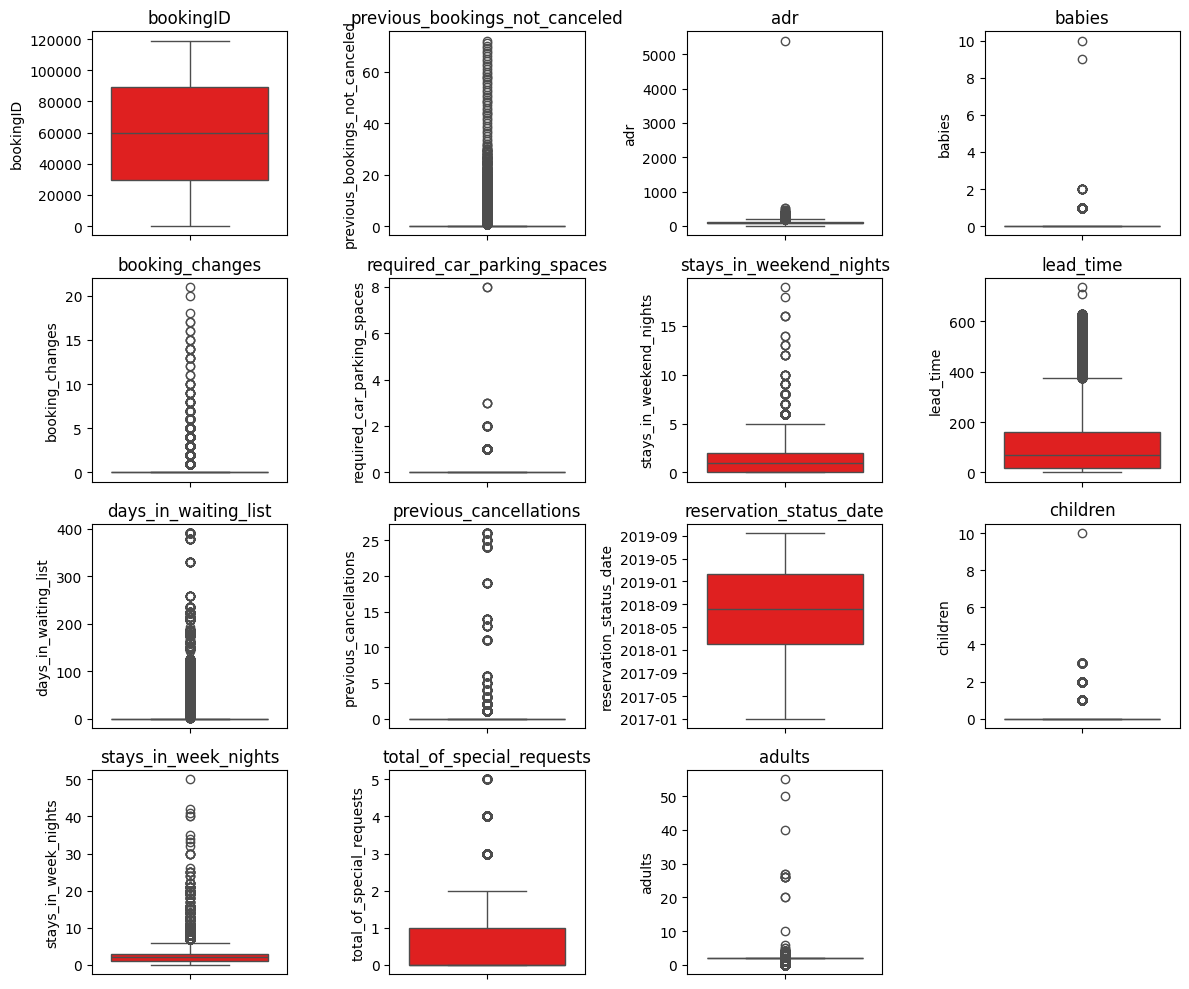

In [43]:
plt.figure(figsize=(12,10))
num_cols = 4  # Jumlah kolom
num_rows = (len(numerical) + num_cols - 1) // num_cols  # Jumlah baris yang diperlukan

features = numerical
for i in range(0, len(features)):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df_outlier_check[features[i]], color='red')
    plt.title(features[i])

plt.tight_layout()
plt.show()

In [44]:
df_outlier_check[df_outlier_check['adr'] > 5000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID
104904,"W Barcelona Barcelona, Spain",NaN,35,2018,March,13,25,0,1,2,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,1,Non Refund,12,0,Transient,5400.0,0,0,Canceled,2018-02-19,104904


Observations:

Terdapat outliers pada dataset. Namun, outlier-outlier yang ada pada dataset sebetulnya masuk akal dan merepresentasikan keadaan asli pada booking perhotelan.

Namun terdapat 1 outlier yang menurut saya tidak masuk akal, yaiut:
- ADR dengan nilai 5400

Hampir tidak mungkin pendapatan rata-rata per hari pada 1 booking dengan nilai `stays_in_weekend_nights` = 0 dan `stays_in_week_night` = 1 bernilai 5400.

Maka kita akan drop outlier tersebut karena tidak masuk akal.

**Checking for `df_train`**

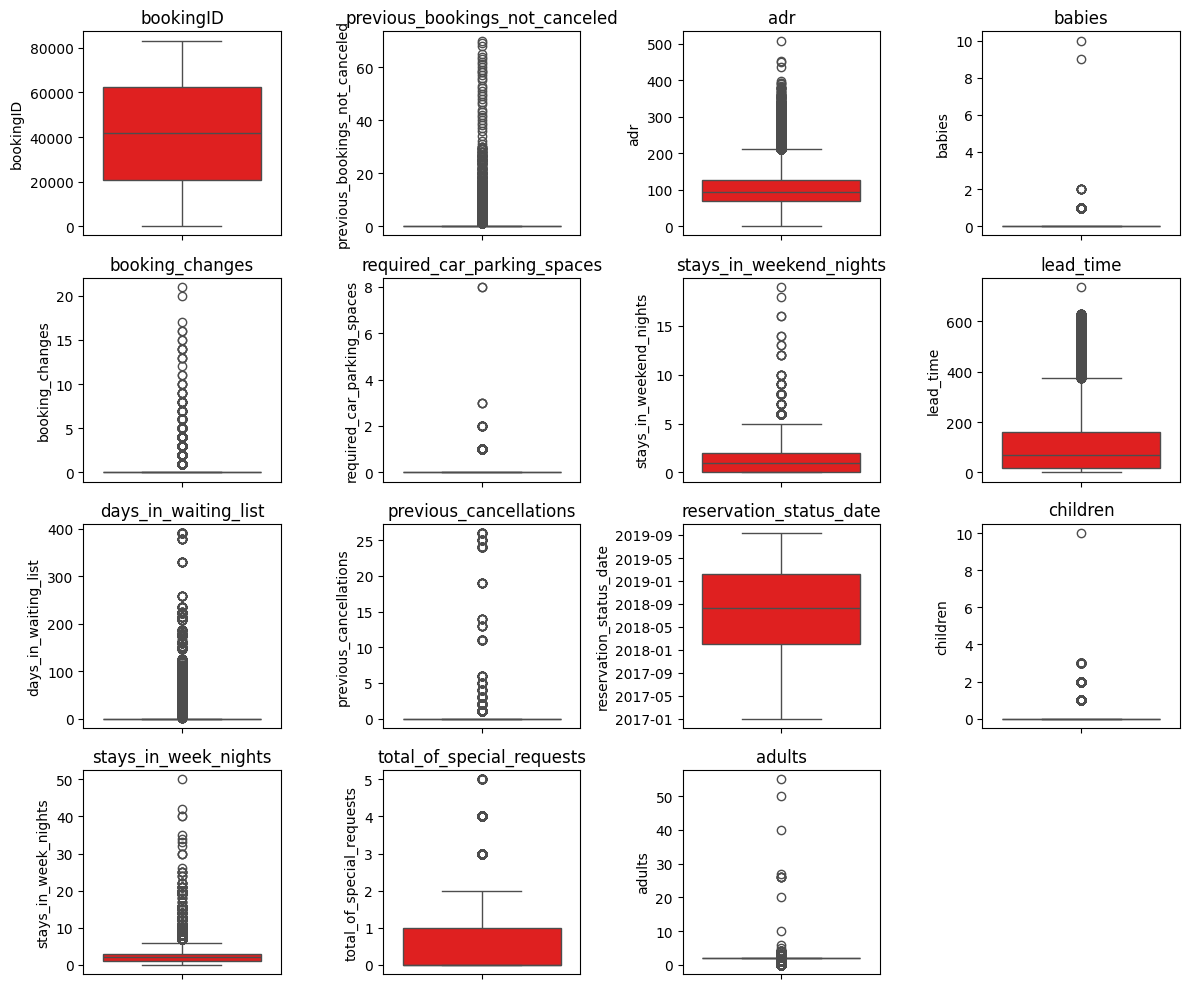

In [45]:
plt.figure(figsize=(12,10))
num_cols = 4  # Jumlah kolom
num_rows = (len(numerical) + num_cols - 1) // num_cols  # Jumlah baris yang diperlukan

features = numerical
for i in range(0, len(features)):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df_train[features[i]], color='red')
    plt.title(features[i])

plt.tight_layout()
plt.show()

**Checking for `df_test`**

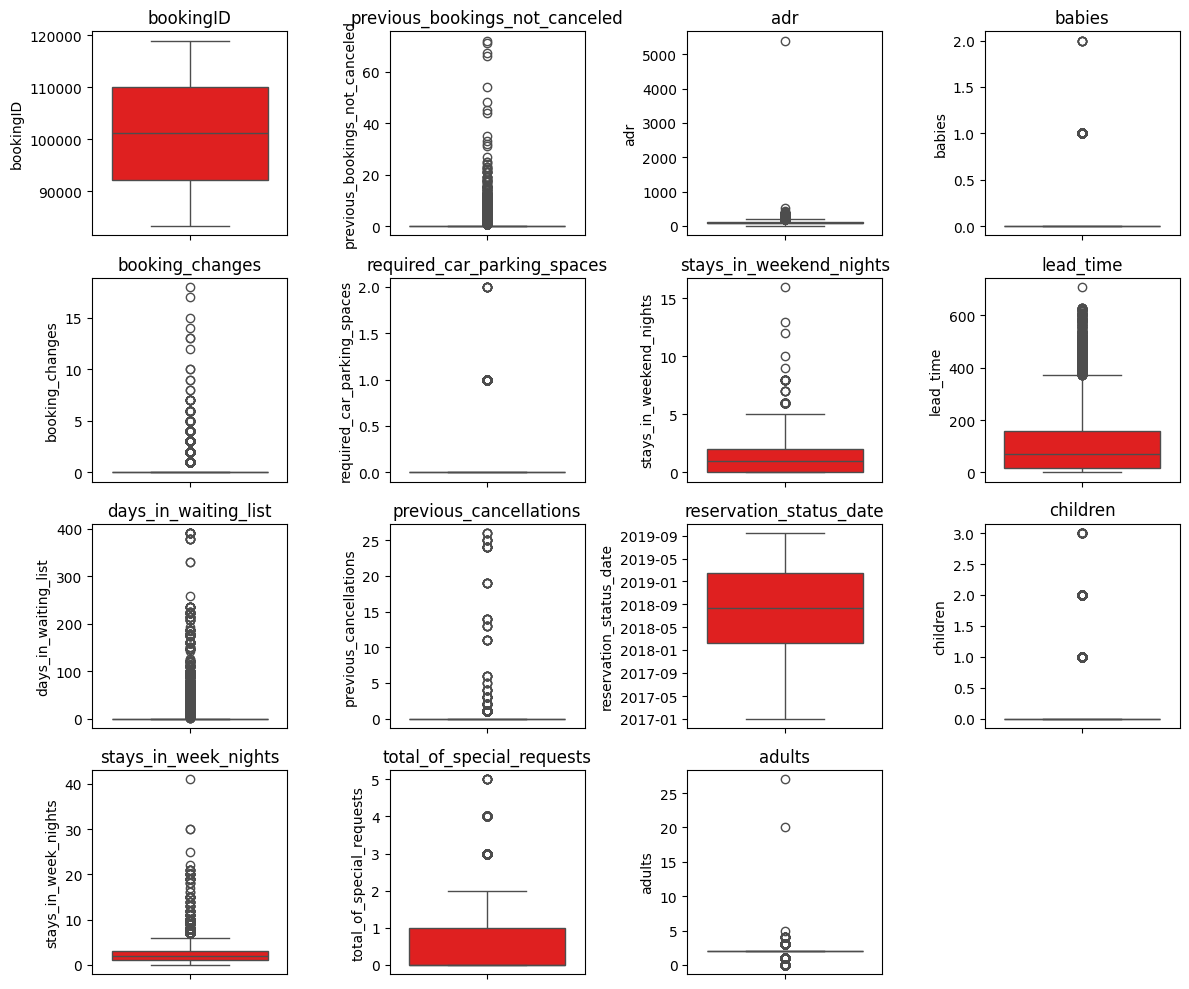

In [46]:
plt.figure(figsize=(12,10))
num_cols = 4  # Jumlah kolom
num_rows = (len(numerical) + num_cols - 1) // num_cols  # Jumlah baris yang diperlukan

features = numerical
for i in range(0, len(features)):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df_test[features[i]], color='red')
    plt.title(features[i])

plt.tight_layout()
plt.show()

Observation:

Ternyata ADR = 5400 ada pada `df_test`

## Handling

In [47]:
df_test = df_test[df_test['adr'] != 5400]

Let's do sanity check

In [48]:
df_test[df_test['adr'] == 5400].shape[0]

0

# Feature Engineering

## total_nights column on train and test data

In [49]:
df_train['total_nights'] = df_train['stays_in_weekend_nights'] + df_train['stays_in_week_nights']
df_test['total_nights'] = df_test['stays_in_weekend_nights'] + df_test['stays_in_week_nights']

numerical.append('total_nights')

## is_cancelled on test data

Karena `is_cancelled` tidak ada di `df_test`, maka kita akan menambahkan kolom `is_cancelled` berdasarkan isian dari `reservation_status`.
- Jika `reservation_status` = 'Check-Out', maka `is_cancelled` = 0
- Jika `reservation_status` != 'Check-Out', maka `is_cancelled` = 1

In [50]:
df_test['is_canceled'] = df_test['reservation_status'].apply(lambda x: 0 if x == 'Check-Out' else 1)

Observation:

Karena `is_canceled` dan `reservation_status` maknanya sama (mengartikan apakah bookingan itu cancel atau tidak), maka kita akan memilih salah satu. Di sini saya memilih `is_canceled` dan drop `reservation_status`.

### Drop `reservation_status` (CANCELLED)

In [51]:
#df_train = df_train.drop(columns=['reservation_status'])
#df_test = df_test.drop(columns=['reservation_status'])

In [52]:
#df_train.head(1)

In [53]:
#df_test.head(1)

# EDA

## Statistical Summary

In [54]:
df_eda = pd.concat([df_train, df_test], ignore_index=True)

In [55]:
df_eda.describe().T

,count,mean,min,25%,50%,75%,max,std
is_canceled,118990.0,0.369493,0.0,0.0,0.0,1.0,1.0,0.48267
lead_time,118990.0,103.767064,0.0,18.0,69.0,160.0,737.0,106.679278
arrival_date_year,118990.0,2018.158602,2017.0,2018.0,2018.0,2019.0,2019.0,0.707192
arrival_date_week_number,118990.0,27.183713,1.0,16.0,28.0,38.0,53.0,13.609474
arrival_date_day_of_month,118990.0,15.786486,1.0,8.0,16.0,23.0,31.0,8.777821
stays_in_weekend_nights,118990.0,0.928969,0.0,0.0,1.0,2.0,19.0,0.999204
stays_in_week_nights,118990.0,2.501815,0.0,1.0,2.0,3.0,50.0,1.910087
adults,118990.0,1.855937,0.0,2.0,2.0,2.0,55.0,0.57999
children,118990.0,0.104009,0.0,0.0,0.0,0.0,10.0,0.398743
babies,118990.0,0.007942,0.0,0.0,0.0,0.0,10.0,0.097343


In [56]:
df_test[df_test['adr'] < 0]

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID,total_nights,is_canceled
12101,"W New York – Times Square New York, NY",195,2019,March,10,5,4,6,2,0,0,BB,GBR,Groups,Direct,1,0,2,A,H,2,No Deposit,273,0,Transient-Party,-6.38,0,0,Check-Out,2019-03-15,95394,10,0


In [57]:
categorical_text = ['hotel', 'arrival_date_month', 'meal', 'country',
                    'market_segment', 'distribution_channel', 'reserved_room_type',
                    'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']
# Assign var categorical_text biar describe untuk kolom "text" bisa muncul

In [58]:
df_eda[categorical_text].describe().T

,count,unique,top,freq
hotel,118990,64,"Las Vegas Marriott Las Vegas, NV",1938
arrival_date_month,118990,12,August,13809
meal,118990,5,BB,91978
country,118990,177,PRT,48805
market_segment,118990,8,Online TA,56366
distribution_channel,118990,5,TA/TO,97513
reserved_room_type,118990,10,A,85660
assigned_room_type,118990,12,A,73751
deposit_type,118990,3,No Deposit,104266
customer_type,118990,4,Transient,89437


## Cancellation Rate

In [59]:
df_eda['is_canceled'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,118990.0,0.369493,0.48267,0.0,0.0,0.0,1.0,1.0


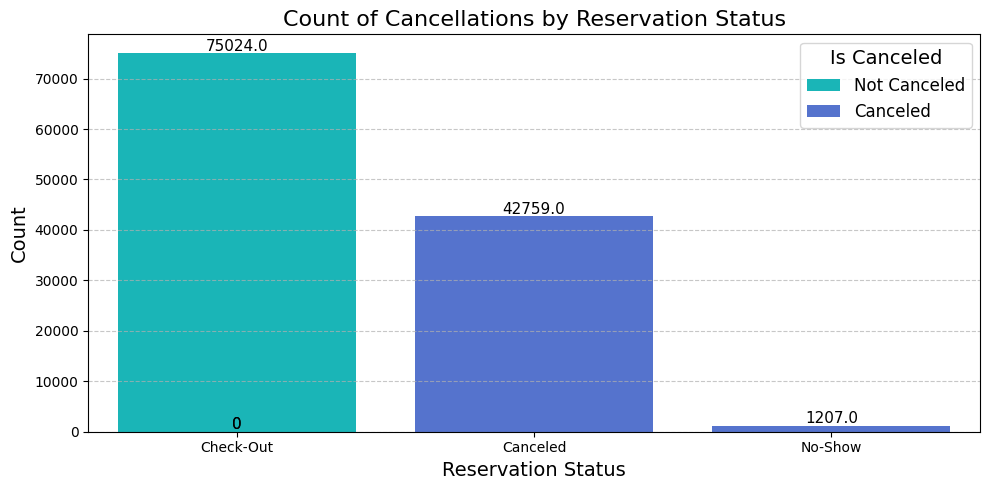

In [60]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='reservation_status', hue='is_canceled', data=df_eda, palette=['darkturquoise', 'royalblue'])

plt.title('Count of Cancellations by Reservation Status', fontsize=16)
plt.xlabel('Reservation Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan anotasi pada bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

Observations:

- Mean dari `is_canceled` sebesar 0.369, artinya adalah tingkat pembatalan sekitar 36.9%, yang mana nilainya cukup besar. Ini menunjukkan tingkat pembatalan yang signifikan yang mungkin perlu dianalisa lebih lanjut.
- Terdapat 1207 pemesanan yang No-Show. Meskipun nilainya kecil dan tidak signifikan, namun No-Show ini bisa berdampak buruk terhadap perusahaan karena bisa menyebabkan hilangnya pendapatan (yang tadinya room bisa disewakan ke customer lain, jadi tidak bisa).

Business Recommendations:
- Kebijakan pembatalan harus dievaluasi. Perusahaan bisa membuat atau menyesuaikan (jika sudah ada) biaya pembatalan untuk mengurangi pembatalan.
- Kebijakan seperti pembayaran di muka atau biaya No-Show bisa dipertimbangkan agar mengurangi nilai No-Show atau bahkan menghilangkan, karena part ini sangat merugikan perusahaan.

## Lead Time

In [61]:
df_eda['lead_time'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
lead_time,118990.0,103.767064,106.679278,0.0,18.0,69.0,160.0,737.0


In [62]:
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750]

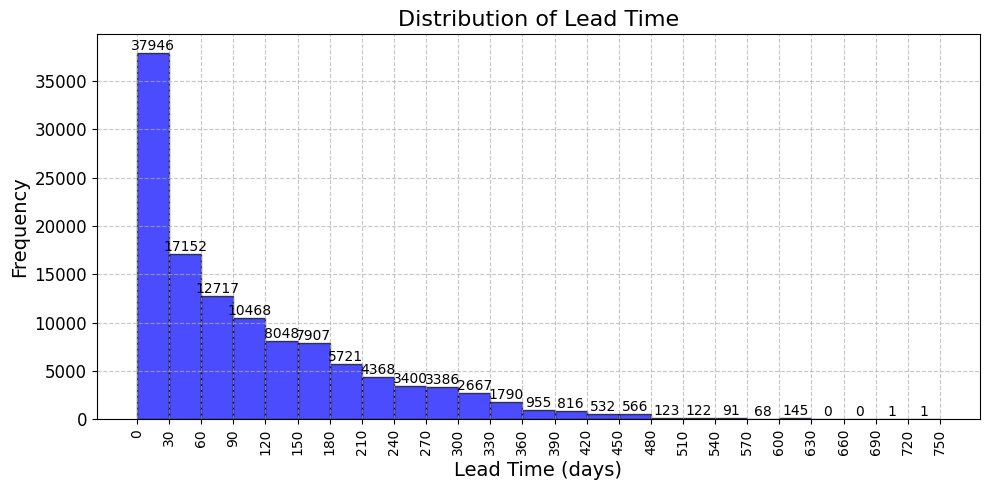

In [63]:
df_eda['lead_time_bins'] = pd.cut(df_eda['lead_time'], bins=bins)

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(df_eda['lead_time'], bins=bins, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Lead Time', fontsize=16)
plt.xlabel('Lead Time (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(bins, rotation=90)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add annotations
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, patches[i].get_height(),
             f'{int(patches[i].get_height())}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

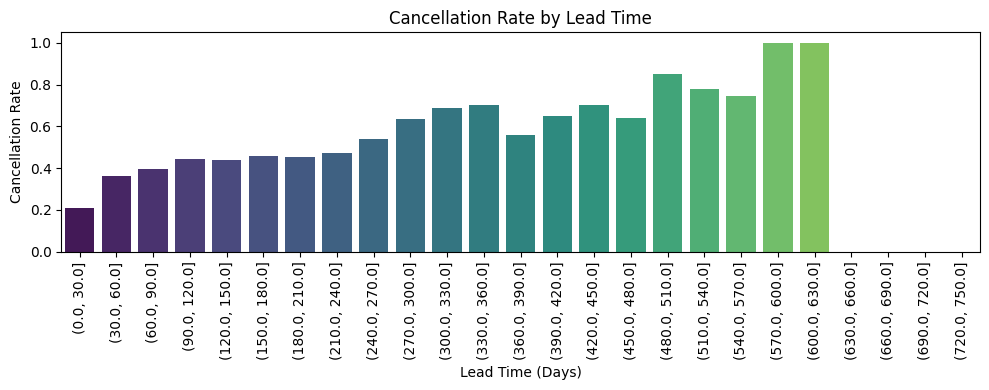

In [64]:
# Buat binning rentang 30 utk visualisasi
lead_time_bins = pd.cut(df_eda['lead_time'], bins=bins)

df_eda['lead_time_bins'] = lead_time_bins

# Hitung mean cancellation rate dari setiap bin
cancellation_rate = df_eda.groupby('lead_time_bins')['is_canceled'].mean()

plt.figure(figsize=(10, 4))
sns.barplot(x=cancellation_rate.index.astype(str), y=cancellation_rate.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Lead Time (Days)')
plt.ylabel('Cancellation Rate')
plt.title('Cancellation Rate by Lead Time')

plt.tight_layout()
plt.show()

In [65]:
# Pesanan dimana Lead time > 630, pesanannya tidak dibatalkan
df_eda[df_eda['lead_time'] > 630]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID,total_nights,lead_time_bins
65083,Protea Hotel by Marriott Cape Town Sea Point C...,0,737,2017,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,0,Transient,0.0,0,0,Check-Out,2017-07-01,65084,0,"(720.0, 750.0]"
103532,"The Westin Peachtree Plaza, Atlanta Atlanta, GA",0,709,2018,February,9,25,8,20,2,0,0,HB,GBR,Direct,Direct,0,0,0,E,E,2,No Deposit,0,0,Transient,68.0,0,0,Check-Out,2018-03-24,103532,28,"(690.0, 720.0]"


Observations:
- Mayoritas pemesanan memiliki `lead_time` yang pendek di bawah 30 hari. Ini menunjukkan bahwa banyak tamu memesan dalam waktu yang relatif dekat dengan tanggal kedatangan.
- Distribusi `lead_time` menurun seiring bertambahnya nilai, dengan sedikit pemesanan yang memiliki `lead_time` besar.
- Berdasarkan `Cancelation Rate by Lead Time`, terlihat jelas bahwa tingkat pembatalan (`is_canceled`) cenderung meningkat seiring dengan meningkatnya nilai `lead_time`
- Pemesanan dengan `lead_time` di bawah 30 hari memiliki rata-rata tingkat pembatalan yang paling rendah
- Pemesanan dengan `lead_time` yang sangat panjang (lebih dari 570 hari) memiliki tingkat pembatalan yang sangat tinggi, mendekati atau mencapai 100% (Kecuali ada 2 pesanan dengan `lead_time` 737 & 709 yang tidak batal).

Business Recommendations:
1. Kebijakan pembatalan yang lebih ketat untuk pemesanan dengan `lead_time` yang panjang.

Hal ini dikarenakan pesanan dengan `lead_time` yang semakin besar, maka kemungkinan batalnya juga semakin besar. Misal: kebijakan mengurangi waktu pembatalan gratis, atau membuat aturan biaya pembatalan.

2. Membuat loyalty program atau memberikan insentif untuk tamu yang memesan dengan `lead_time` panjang dan tidak membatalkan.

Bisa dengan memberikan poin atau diskon yang bisa dipakai di kemudian hari.

## Distribusi Pinjaman

In [66]:
df_eda['is_canceled'].value_counts()

is_canceled
0    75024
1    43966
Name: count, dtype: int64

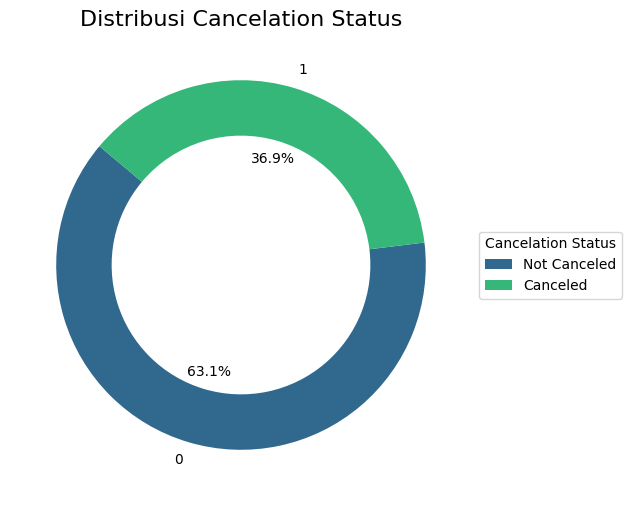

In [67]:
status_counts = df_eda['is_canceled'].value_counts()

plt.figure(figsize=(12, 6))
colors = sns.color_palette("viridis", len(status_counts))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.3))
plt.title('Distribusi Cancelation Status', size=16)

# Adding legend
plt.legend(title='Cancelation Status', labels=['Not Canceled', 'Canceled'], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

## Pengaruh Deposit Type terhadap Cancellation

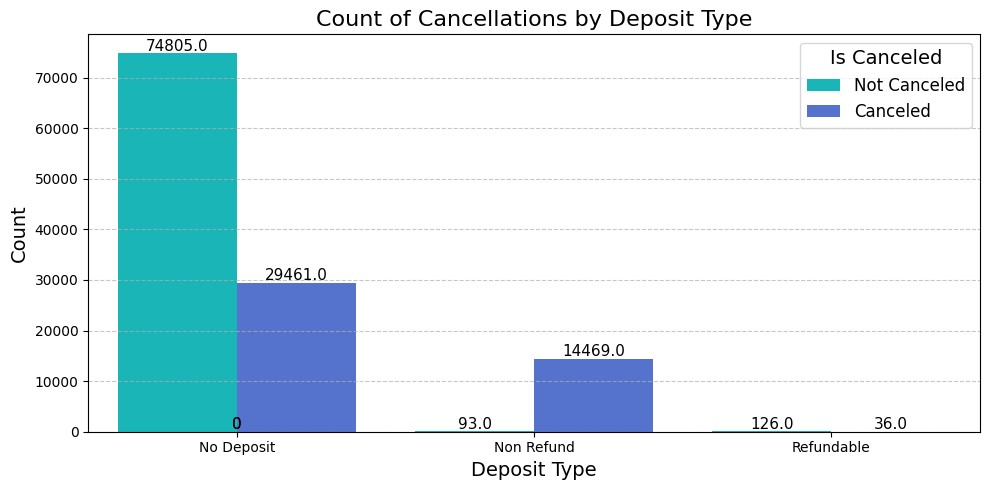

In [68]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='deposit_type', hue='is_canceled', data=df_eda, palette=['darkturquoise', 'royalblue'])

plt.title('Count of Cancellations by Deposit Type', fontsize=16)
plt.xlabel('Deposit Type', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan anotasi pada bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Is Canceled', labels=['Not Canceled', 'Canceled'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

Observations:

- Mayoritas pemesanan dengan No Deposit tidak dibatalkan. Padahal opsi No Deposit mungkin memberikan fleksibilitas yang lebih tinggi kepada pelanggan sehingga pelanggan bisa bebas melakukan pembatalan tanpa penalti
- Sebagian besar pemesanan Non Refund dibatalkan. Hal ini menunjukkan bahwa meskipun deposit Non Refund dimaksudkan untuk mengurangi pembatalan, banyak tamu tetap membatalkan pemesanan
- Pemesanan dengan deposit Refundable memiliki tingkat pembatalan yang sangat rendah. Sama seperti No Deposit, opsi Refundable mungkin memberikan fleksibilitas yang lebih tinggi kepada pelanggan sehingga pelanggan bisa bebas melakukan pembatalan tanpa penalti. Tetapi nilai pembatalannya malah rendah

Business Recommendation:
1. Lakukan evaluasi ulang terhadap kebijakan Non Refund

Kebijakan deposit yang tidak dapat dikembalikan ternyata tidak cukup efektif dalam mengurangi pembatalan. Mungkin dibandingkan dengan menggunakan metode Non Refund, perusahaan bisa menawarkan insentif khusus untuk tamu yang tidak membatalkan agar bisa membantu menurunkan tingkat pembatalan.

## Reservation Month terhadap ADR

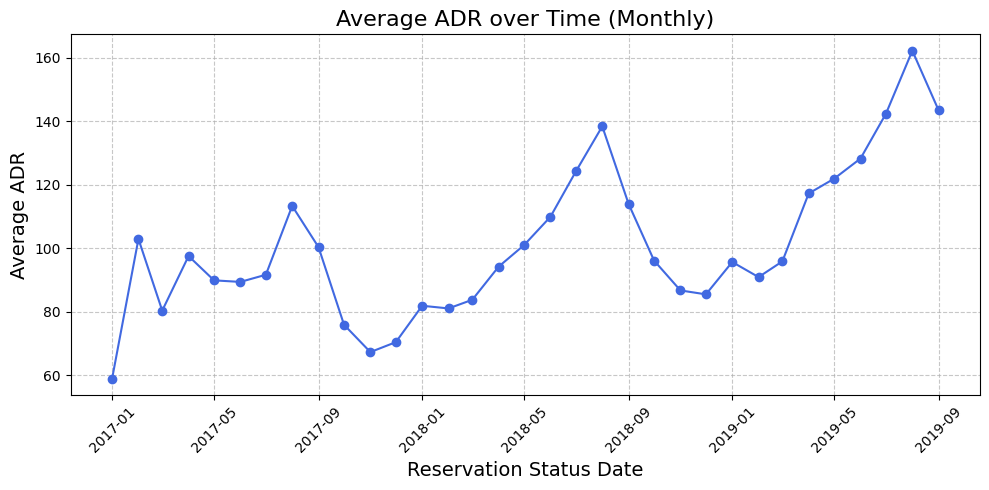

In [69]:
df_eda['month_year'] = df_eda['reservation_status_date'].dt.to_period('M')
monthly_avg_adr = df_eda.groupby('month_year')['adr'].mean().reset_index()
monthly_avg_adr['month_year'] = monthly_avg_adr['month_year'].dt.to_timestamp()

# Plot data agregat
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_adr['month_year'], monthly_avg_adr['adr'], marker='o', linestyle='-', color='royalblue')

plt.title('Average ADR over Time (Monthly)', fontsize=16)
plt.xlabel('Reservation Status Date', fontsize=14)
plt.ylabel('Average ADR', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Observations:
- Terlihat ADR tertinggi selalu pada bulan ke 8, dan tren positif dari bulan ke 3 menuju bulan ke 8.
- ADR selalu mengalami posisi menurun di bulan 8 ke atas, dan mulai meningkat lagi di bulan ke 3

Business Recommendations:
1. Promosi pada bulan-bulan spesifik untuk meningkatkan keterisian kamar.

Pada bulan-bulan dimana ADR menurun, bisa dirancang promosi khusus pada range bulan 9 (September) sampai 3 (Maret). Promosi bisa mencakup diskon, paket bundling, atau penawaran khusus untuk acara.

2. Melaksanakan strategi harga musiman, jika belum dilaksanakan

Perusahaan bisa memanfaatkan fluktuasi musiman ini. Misalnya, menaikkan harga selama bulan-bulan dengan permintaan tinggi dan turunkan harga selama bulan-bulan dengan permintaan rendah untuk memaksimalkan pendapatan.

## Banyak Total Night Pelanggan

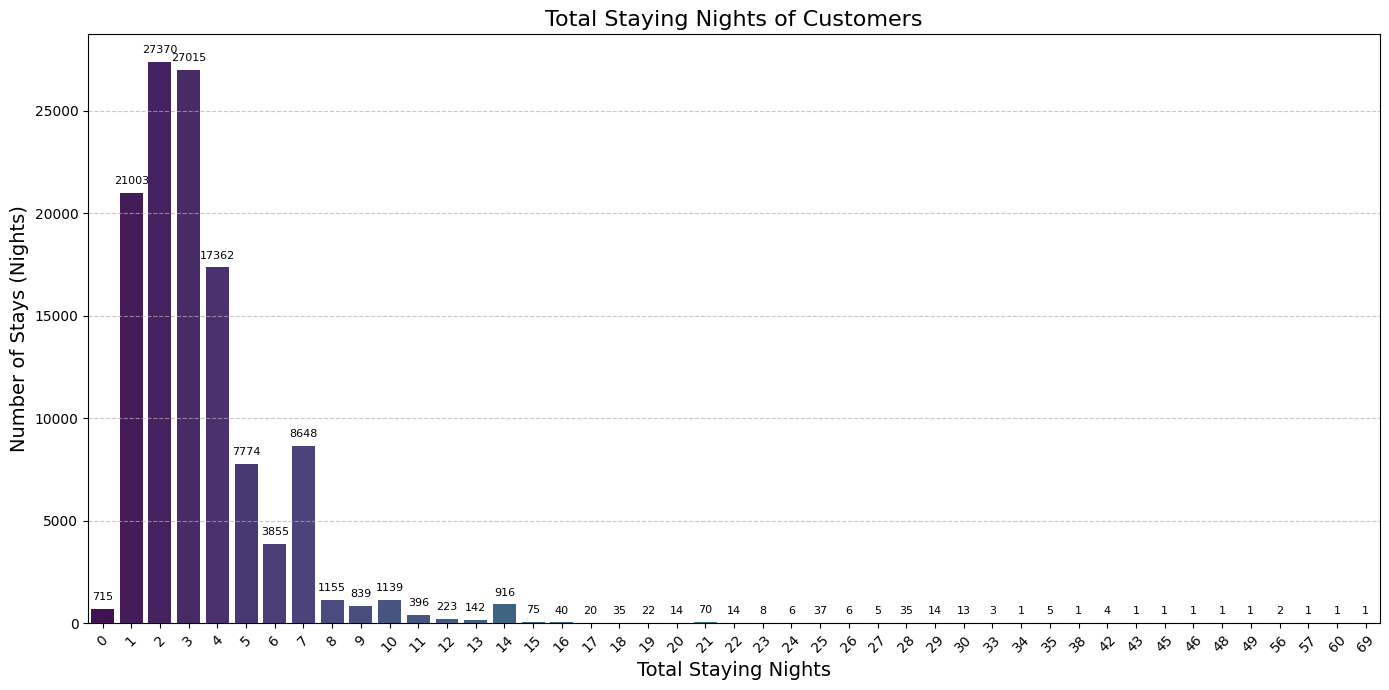

In [70]:
plt.figure(figsize=(14, 7))
ax = sns.countplot(x='total_nights', data=df_eda, palette='viridis')

plt.title('Total Staying Nights of Customers', fontsize=16)
plt.xlabel('Total Staying Nights', fontsize=14)
plt.ylabel('Number of Stays (Nights)', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan anotasi
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Observations:
- Mayoritas customer menginap selama 1 hingga 3 malam, dengan puncaknya pada 2 malam dan 3 malam menginap.
- Lama menginap lebih dari 7 malam sangat jarang terjadi. Dapat dilihat bahwa kemunculan 7 dan 8 memiliki perbedaan yang besar.
- Pelanggan cenderung memilih menginap untuk waktu singkat. Mungkin ini mengindikasikan bahwa hotel lebih sering digunakan untuk perjalanan bisnis atau kunjungan singkat, daripada liburan panjang. Dan hipotesis ini sebetulnya valid, karena berdasarakan Statistical Summary Insight di atas sebelumnya, memang rata-rata menginap adalah -> Weekend 0.93 malam & Weekday 2.5 malam

Business Recommendations:
1. Diskon Progresif untuk menginap lama

Untuk menarik pelanggan yang berpotensi menginap lebih lama, perusahaan bisa menawarkan diskon progresif untuk setiap malam tambahan yang dipesan setelah 3 malam. Misalnya, diskon 10% untuk malam ke-4, 15% untuk malam ke-5, dan seterusnya

2. Cek segmentasi pelanggan yang menginap lama

Identifikasi segmen pelanggan yang menginap > 3 hari. Lalu buat promosi yang ditargetkan untuk segmentasi ini, sehingga menarik pelanggan yang menginap > 3 hari.

## Reservation Month terhadap Cancellation

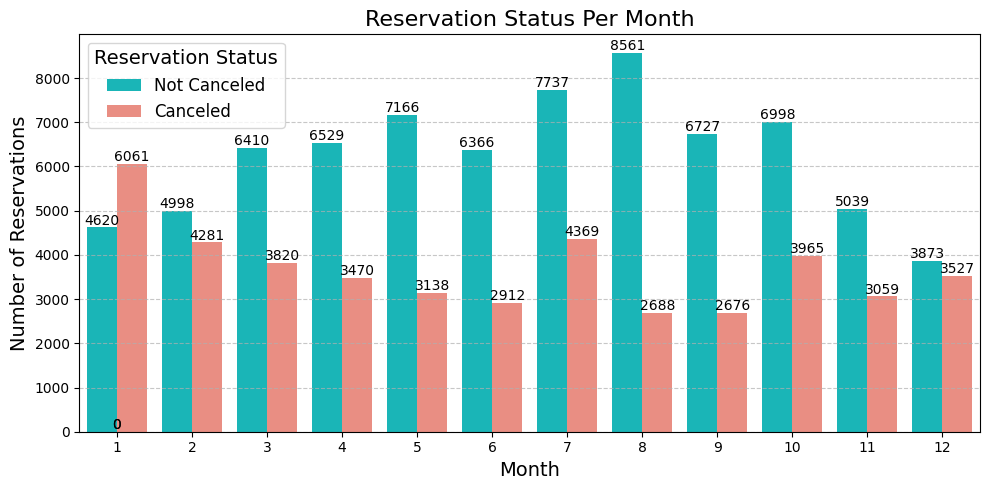

In [71]:
df_eda['month'] = df_eda['reservation_status_date'].dt.month

plt.figure(figsize=(10, 5))
ax = sns.countplot(x='month', hue='is_canceled', data=df_eda, palette=['darkturquoise', 'salmon'])

plt.title('Reservation Status Per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Reservations', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Reservation Status', labels=['Not Canceled', 'Canceled'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

Observations:
- Bulan yang memiliki rasio pembatalan (berdasarkan Not Canceled vs Canceled) tertinggi berdasarkan bulan pemesanannya adalah: 1 (Januari), 2 (Februari), 12 (Agustus)
- Bulan 7 (Juli) dan 8 (Agustus) memiliki jumlah pemesanan Not Canceled paling tinggi. Sepertinya ini ada hubungan dengan liburan musim panas, dimana timeline tersebut memiliki tingkat reservasi yang lebih tinggi dan kemungkinan pembatalan yang lebih rendah.

Business Recommendations:
1. Promosi pada bulan dengan tingkat pembatalan tinggi

pada bulan yang memiliki rasio pembatalan tinggi, seperti: Januari, Februari, Agustus, perusahaan bisa memberikan promo atau insentif untuk pelanggan yang melakukan reservasi di bulan-bulan ini. Misal: Perusahaan bisa menawarkan insentif khusus untuk tamu yang tidak membatalkan agar bisa membantu menurunkan tingkat pembatalan.

Notes: Jika insentif yang diberikan adalah semacam diskon tambahan untuk reservasi Non Refundable, ini tidak disarankan. Karena berdasarkan EDA `Pengaruh Deposit Type terhadap Cancellation`, dapat disimpulkan bahwa reservasi Non Refundable pun tidak menjamin pesanan tidak dibatalkan. Dan juga berdasarkan grafik di bawah (lihat grafik di bawah ini), jumlah pesanan Non Refundable paling banyak di bulan 1 (Januari). Jadi Non Refundable tidak memiliki pengaruh.

2. Promosi khusus untuk meningkatkan pendapatan pada bulan dengan tingkat Not Canceled tertinggi

Bulan Juli dan Agustus memiliki tingkat pemesanan Not Canceled tertinggi. Perusahaan bisa memanfaatkan tren tinggi ini dengan menawarkan paket bundle lainnya untuk menaikkan sales, seperti paket wisata, paket liburan, paket keluarga, dll agar bisa lebih menarik pada bulan-bulan ini.

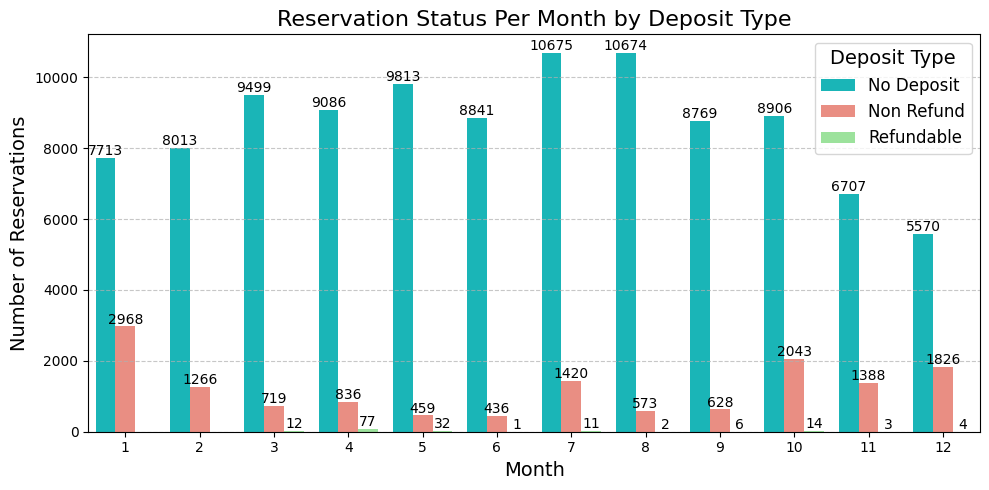

In [72]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='month', hue='deposit_type', data=df_eda, palette=['darkturquoise', 'salmon', 'lightgreen'])

plt.title('Reservation Status Per Month by Deposit Type', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Reservations', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding annotations
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.legend(title='Deposit Type', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

In [73]:
df_eda.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID,total_nights,lead_time_bins,month_year,month
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314,0,Transient,38.4,0,0,Check-Out,2019-01-14,1,4,"(0.0, 30.0]",2019-01,1


## Persentase Jenis Meals

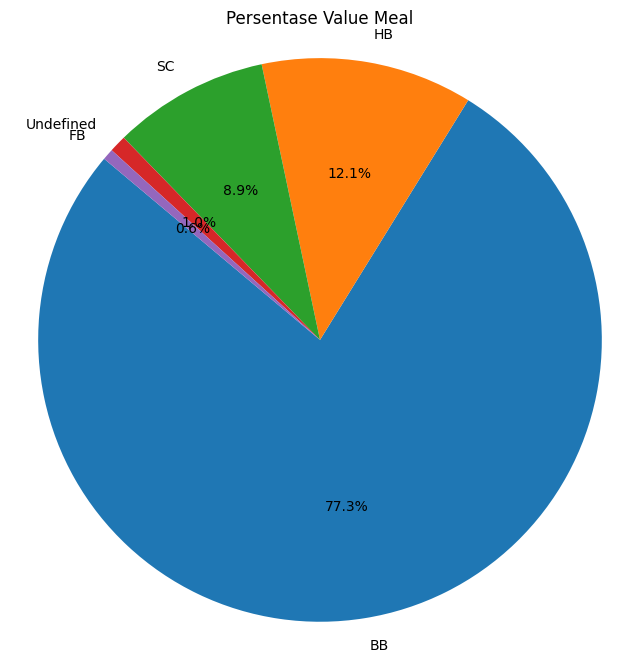

In [74]:
meal_counts = df_eda['meal'].value_counts()
meal_percentages = meal_counts / meal_counts.sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(meal_percentages, labels=meal_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Persentase Value Meal')
plt.axis('equal')  # Biar lingkaran

plt.show()

Observations:
- Bed and Breakfast (BB) merupakan mayoritas dengan persentase 77.3%. Hal ini menunjukkan bahwa kebanyakan tamu lebih suka mendapatkan sarapan / sarapan di kamar.

Business Recommendations:
- Karena mayoritas BB, maka perusahaan hotel harus memastikan kalau kualitas sarapan pagi mereka baik, untuk meningkatkan kunjungan tamu berulang.

## Country terhadap Cancellation (Tambahan insight after Feature Importance Result)

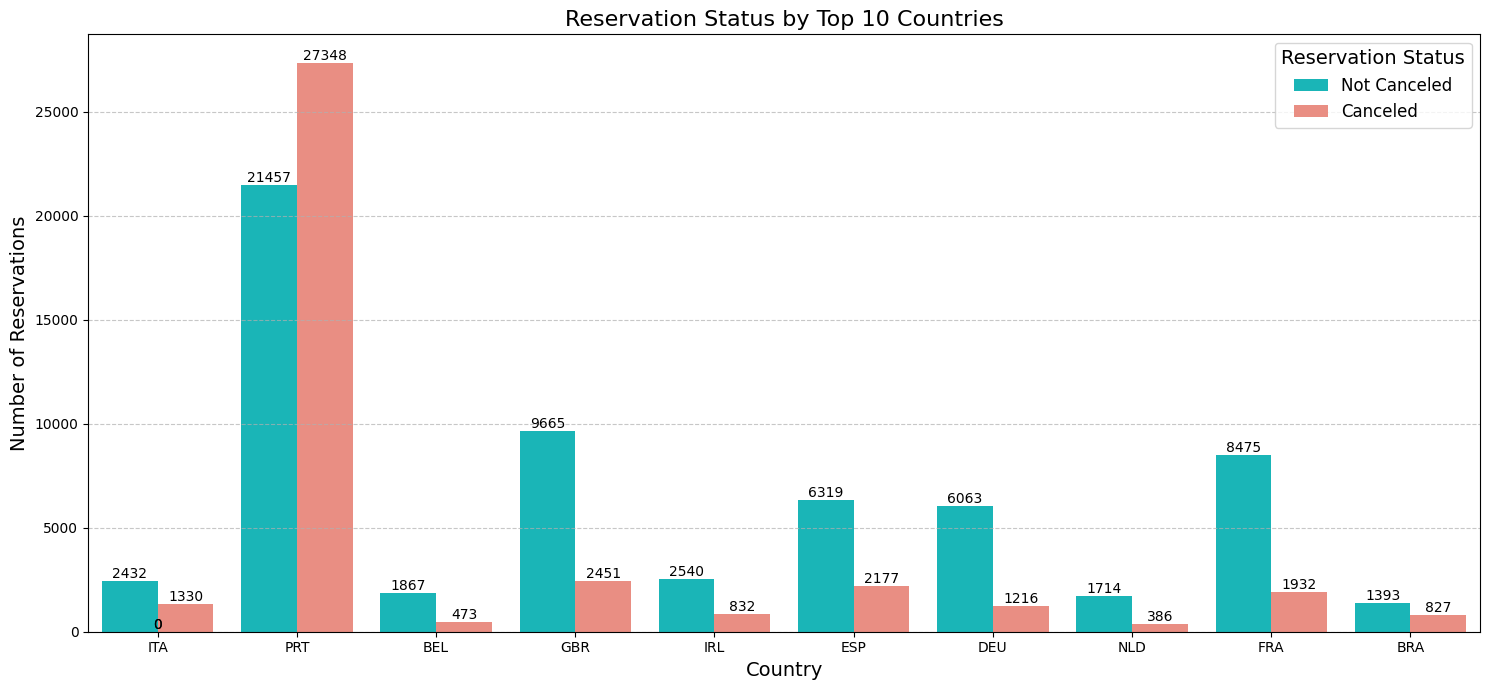

In [75]:
country_counts = df_eda['country'].value_counts()
top_countries = country_counts.head(10).index
df_top_countries = df_eda[df_eda['country'].isin(top_countries)]

plt.figure(figsize=(15, 7))
ax = sns.countplot(x='country', hue='is_canceled', data=df_top_countries, palette=['darkturquoise', 'salmon'])

plt.title('Reservation Status by Top 10 Countries', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Reservations', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan anotasi pada bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Reservation Status', labels=['Not Canceled', 'Canceled'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

## Market Segment terhadap Cancellation (Tambahan insight after Feature Importance Result)

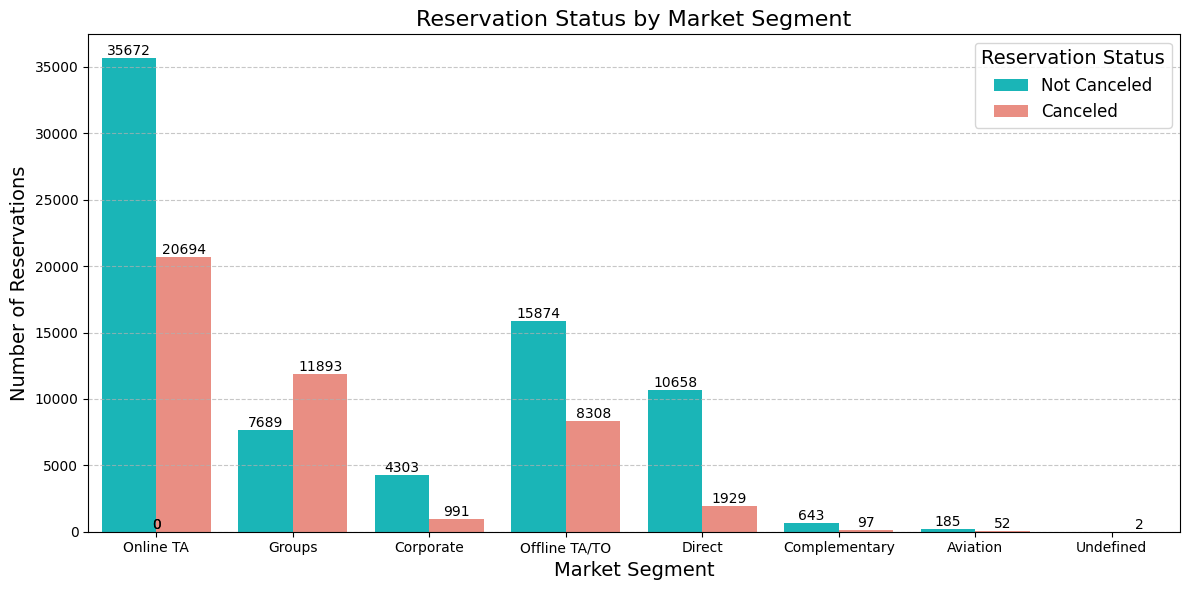

In [76]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='market_segment', hue='is_canceled', data=df_eda, palette=['darkturquoise', 'salmon'])

plt.title('Reservation Status by Market Segment', fontsize=16)
plt.xlabel('Market Segment', fontsize=14)
plt.ylabel('Number of Reservations', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan anotasi pada bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Reservation Status', labels=['Not Canceled', 'Canceled'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

## Agent terhadap Cancellation (Tambahan insight after Feature Importance Result)

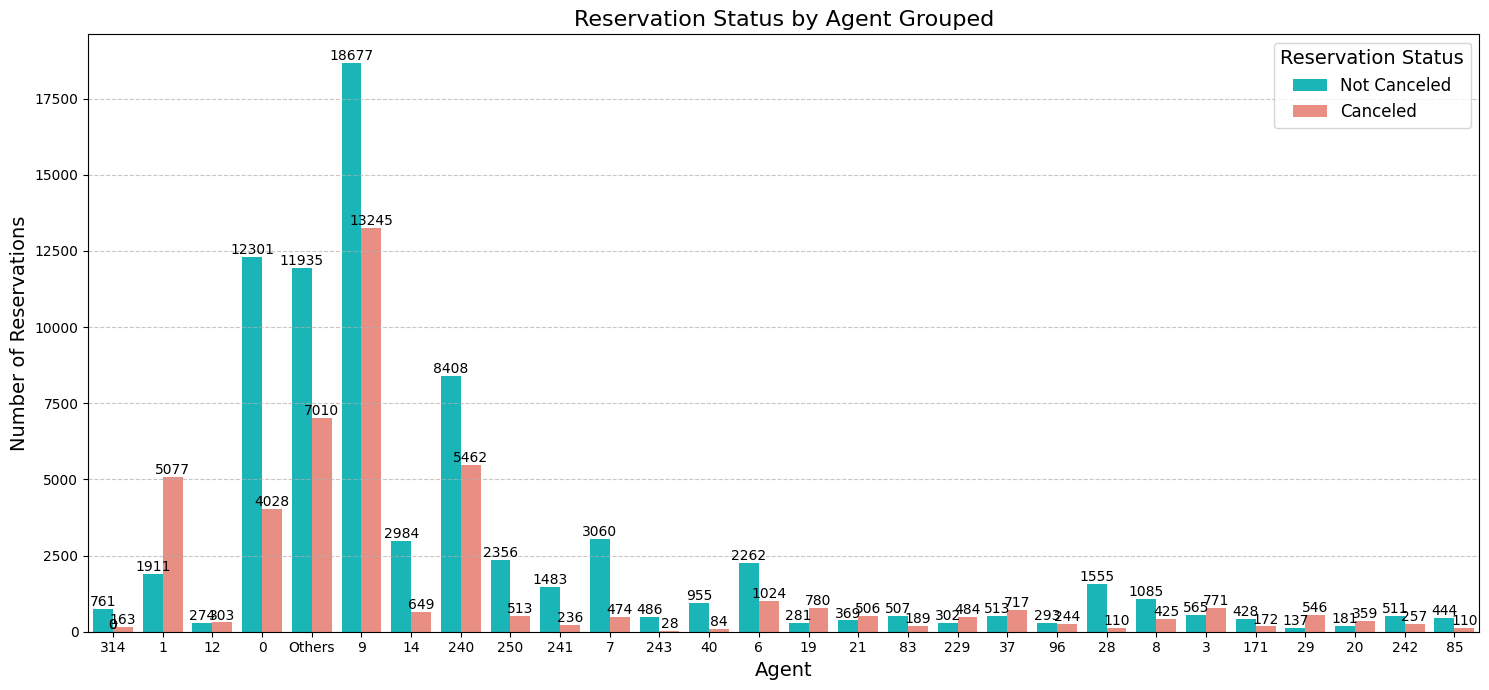

In [77]:
agent_counts = df_eda['agent'].value_counts()
threshold = 500
df_eda['agent_grouped'] = df_eda['agent'].apply(lambda x: x if agent_counts[x] >= threshold else 'Others')

plt.figure(figsize=(15, 7))
ax = sns.countplot(x='agent_grouped', hue='is_canceled', data=df_eda, palette=['darkturquoise', 'salmon'])

plt.title('Reservation Status by Agent Grouped', fontsize=16)
plt.xlabel('Agent', fontsize=14)
plt.ylabel('Number of Reservations', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menambahkan anotasi pada bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='Reservation Status', labels=['Not Canceled', 'Canceled'], fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

# Multicollinearity Check

In [78]:
# Kita buat `df_correlation_check` agar lebih mudah menganalisa `df_train` dan `df_test`
df_correlation_check = pd.concat([df_train, df_test], ignore_index=True)

In [79]:
df_correlation_check.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID,total_nights
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,0,4,2,0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314,0,Transient,38.4,0,0,Check-Out,2019-01-14,1,4


In [80]:
numeric_columns = list(df_train.select_dtypes(include=[float, int]).columns)

In [81]:
# calculate VIF scores for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

constant = add_constant(df_correlation_check[numeric_columns])

vif_df = pd.DataFrame([vif(constant.values, i)
               for i in range(constant.shape[1])],
              index=constant.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,is_canceled,1.230041
2,lead_time,1.275884
3,arrival_date_year,1.679838
4,arrival_date_week_number,1.598392
5,arrival_date_day_of_month,1.009528
6,stays_in_weekend_nights,inf
7,stays_in_week_nights,inf
8,adults,1.126155
9,children,1.145783
10,babies,1.018407


<Axes: >

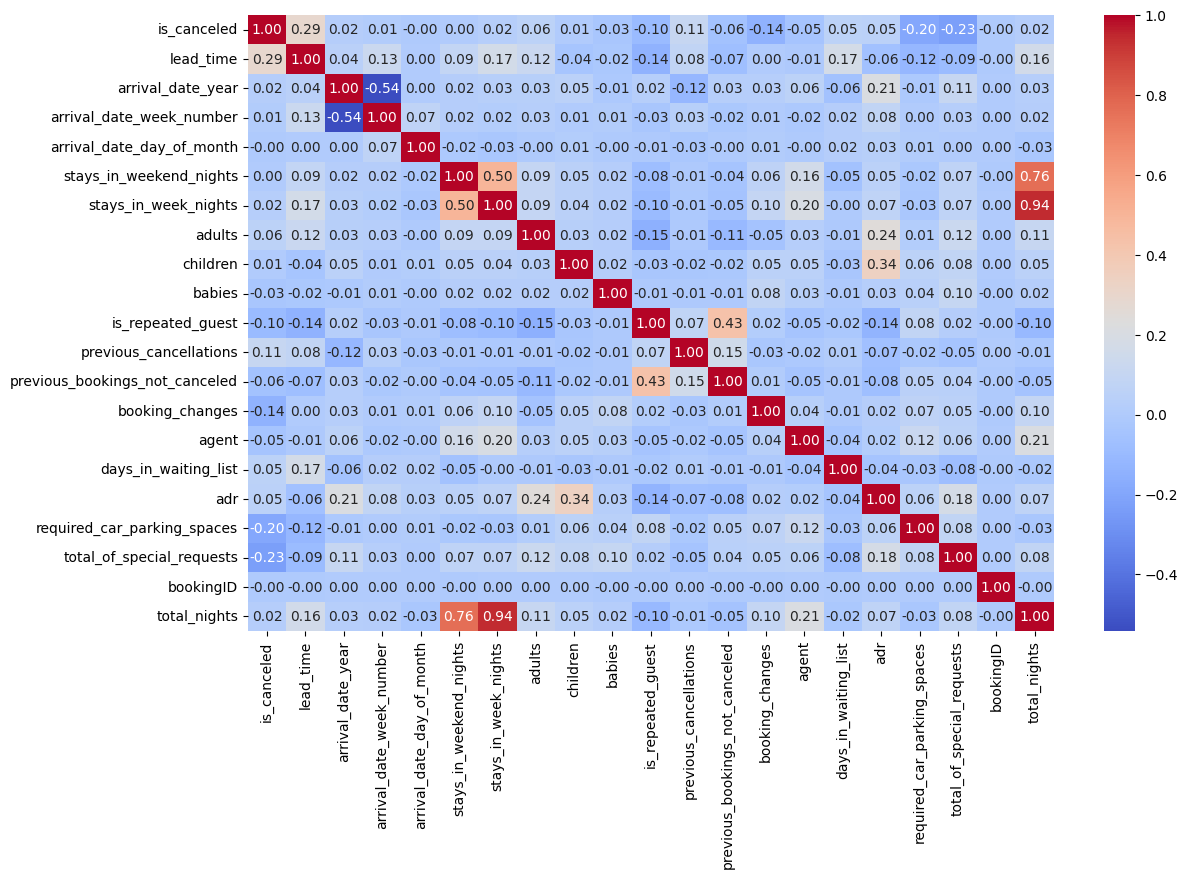

In [82]:
plt.figure(figsize=(13,8))
correlation = df_correlation_check[numeric_columns].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')

Observations:
- `total_nights` & `stays_in_weekend_nights` memiliki nilai korelasi 0.76
- `total_nights` & `stays_in_week_nights` memiliki nilai korelas 0.94
- Karena `total_nights` adalah kombinasi dari `stays_in_weekend_nights` & `stays_in_week_nights`, kita bisa keep total_nights dan membuang kedua kolom asli.
- Namun untuk memastikannya lagi, saya akan lakukan feature importance dulu antara `total_nights`, `stays_in_weekend_nights` dan `stays_in_week_nights` untuk menentukan feature mana yang paling berpengaruh terhadap model.

**Check feature importance `total_nights`, `stays_in_weekend_nights`, `stays_in_week_nights` terhadap model**

In [83]:
X_corr_check = df_train[['total_nights', 'stays_in_weekend_nights', 'stays_in_week_nights']]
y_corr_check = df_train['is_canceled']

model = RandomForestClassifier()
model.fit(X_corr_check, y_corr_check)

feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': ['total_nights', 'stays_in_weekend_nights', 'stays_in_week_nights'],
    'Importance': feature_importances
})

print(importance_df.sort_values(by='Importance', ascending=False))

                   Feature  Importance
0             total_nights    0.553070
2     stays_in_week_nights    0.312345
1  stays_in_weekend_nights    0.134585


Result:
- Ternyata memang `total_nights` yang memiliki nilai feature importance tertinggi dibanding yang lain. Maka memang decision untuk keep `total_nights` terbaik, dan menghapus `stays_in_weekend_nights`, `stays_in_week_nights` paling ideal.

In [84]:
df_train = df_train.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'])
df_test = df_test.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'])
df_correlation_check = df_correlation_check.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'])

In [85]:
numeric_columns.remove('stays_in_weekend_nights')
numeric_columns.remove('stays_in_week_nights')

In [86]:
# calculate VIF scores for each feature
constant = add_constant(df_correlation_check[numeric_columns])

vif_df = pd.DataFrame([vif(constant.values, i)
               for i in range(constant.shape[1])],
              index=constant.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,is_canceled,1.229964
2,lead_time,1.273462
3,arrival_date_year,1.679760
4,arrival_date_week_number,1.598012
5,arrival_date_day_of_month,1.009475
6,adults,1.125506
7,children,1.145569
8,babies,1.018406
9,is_repeated_guest,1.289691
10,previous_cancellations,1.066408


# Encoding for categorical features to numerical

## `df_train`

### Check

In [87]:
df_train.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID,total_nights
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,2,0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314,0,Transient,38.4,0,0,Check-Out,2019-01-14,1,4


In [88]:
non_numeric_columns = df_train.select_dtypes(exclude=['int', 'float']).columns

unique_values = df_train[non_numeric_columns].apply(lambda x: x.unique())
print(unique_values)

hotel                      [Crystal Cove, Barbados Barbados, Greensboro C...
arrival_date_month         [January, December, May, October, September, M...
meal                                             [BB, HB, SC, FB, Undefined]
country                    [ITA, PRT, BEL, DNK, GBR, IRL, ESP, DEU, RUS, ...
market_segment             [Online TA, Groups, Corporate, Offline TA/TO, ...
distribution_channel              [TA/TO, Corporate, Direct, GDS, Undefined]
reserved_room_type                            [A, D, E, G, F, H, B, C, P, L]
assigned_room_type                         [A, D, E, C, F, G, H, B, K, I, P]
deposit_type                            [No Deposit, Non Refund, Refundable]
customer_type                  [Transient, Contract, Transient-Party, Group]
reservation_status                            [Check-Out, Canceled, No-Show]
reservation_status_date    [2019-01-14 00:00:00, 2017-10-21 00:00:00, 201...
dtype: object


In [89]:
# Unique vals yang tidak terlihat (karena terlalu banyak) di atas kita buka lagi
lister = ['hotel', 'arrival_date_month', 'country', 'market_segment']

for i in lister:
  print(f'{i}:', df_train[i].unique(), '\n')

hotel: ['Crystal Cove, Barbados Barbados' 'Greensboro Courtyard Greensboro, NC'
 'The Westin Peachtree Plaza, Atlanta Atlanta, GA '
 'Courtyard by Marriott Aberdeen Airport Aberdeen, United Kingdom'
 'W New York – Union Square New York, NY'
 'Hotel Maria Cristina, San Sebastian San Sebastian, Spain'
 'W New York – Times Square New York, NY'
 'The Ritz-Carlton, Tokyo Tokyo, Japan'
 'Marriott Puerto Vallarta Resort & Spa Puerto Vallarta, Mexico'
 'Las Vegas Marriott Las Vegas, NV '
 'Heidelberg Marriott Hotel Heidelberg, Germany'
 'Sheraton Grand Rio Hotel & Resort Rio de Janeiro, Brazil'
 'Renaissance Hamburg Hotel Hamburg, Germany'
 'The Ritz-Carlton, Berlin Berlin, Germany'
 'Sheraton Lima Hotel & Convention Center Lima, Peru'
 'Courtyard Las Vegas Convention Center Las Vegas, NV '
 'Newark Liberty International Airport Courtyard Newark, NJ'
 'Indianapolis Airport Courtyard Indianapolis, IN'
 'Treasure Beach, Barbados Barbados'
 'Cape Town Marriott Hotel Crystal Towers Cape Town, Sout

Observations:

- `reservation_status` sebetulnya mengartikan hal yang sama dengan `is_canceled`, dan tidak akan menjadi prediktor yang baik. Di sini kita akan drop `reservation_status`
- `reservation_status_date` sebelum dilakukan encoding, akan kita pecah menjadi format `tahun`, `bulan`, dan `tanggal` terlebih dahulu, dengan detail seperti di bawah ini:

1. `tahun` pada `reservation_status_date` akan dibuat kolom bernama `reservation_date_year`
2. `bulan` pada `reservation_status_date` akan dibuat kolom bernama `reservation_date_month`
3. `bulan` pada `reservation_status_date` akan dibuat kolom bernama `reservation_date_day_of_month`

### Drop `reservation_status`

In [90]:
df_train.drop(columns=['reservation_status'], inplace = True)

### Feature Engineering (2) for `reservation_status_date`

`reservation_status_date` kita pecah menjadi format `tahun`, `bulan`, dan `tanggal`

In [91]:
df_train['reservation_date_year'] = pd.to_datetime(df_train['reservation_status_date']).dt.year
df_train['reservation_date_month'] = pd.to_datetime(df_train['reservation_status_date']).dt.month
df_train['reservation_date_day_of_month'] = pd.to_datetime(df_train['reservation_status_date']).dt.day

`reservation_status_date` kita drop:

In [92]:
df_train.drop(columns=['reservation_status_date'], inplace = True)

### Frequency encoding

In [93]:
non_numeric_columns = df_train.select_dtypes(exclude=['int', 'float']).columns

unique_values = df_train[non_numeric_columns].apply(lambda x: x.unique())
print(unique_values)

hotel                   [Crystal Cove, Barbados Barbados, Greensboro C...
arrival_date_month      [January, December, May, October, September, M...
meal                                          [BB, HB, SC, FB, Undefined]
country                 [ITA, PRT, BEL, DNK, GBR, IRL, ESP, DEU, RUS, ...
market_segment          [Online TA, Groups, Corporate, Offline TA/TO, ...
distribution_channel           [TA/TO, Corporate, Direct, GDS, Undefined]
reserved_room_type                         [A, D, E, G, F, H, B, C, P, L]
assigned_room_type                      [A, D, E, C, F, G, H, B, K, I, P]
deposit_type                         [No Deposit, Non Refund, Refundable]
customer_type               [Transient, Contract, Transient-Party, Group]
dtype: object


In [94]:
# Jumlah unique vals yang tidak terlihat (karena terlalu banyak) di atas kita buka lagi
lister = ['hotel', 'arrival_date_month', 'country', 'market_segment']

for i in lister:
  print(f'{i}:', len(df_train[i].unique()), '\n')

hotel: 64 

arrival_date_month: 12 

country: 165 

market_segment: 8 



Kita akan melakukan frequency encoding berdasarkan persentase kemunculan value pada tiap kolom.

List of categorical features that has >= 3 values, will use Frequency Encoding:
- `hotel`
- `arrival_date_month`
- `meal`
- `country`
- `market_segment`
- `distribution_channel`
- `reserved_room_type`
- `assigned_room_type`
- `deposit_type`
- `customer_type`

In [95]:
to_encode = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type']

def frequency_encoding(column):
    freq_encoding = df_train[column].value_counts() / len(df_train)
    return df_train[column].map(freq_encoding)

for col in to_encode:
    df_train['pct_' + col] = frequency_encoding(col)

In [96]:
df_train.head(1)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,bookingID,total_nights,reservation_date_year,reservation_date_month,reservation_date_day_of_month,pct_hotel,pct_arrival_date_month,pct_meal,pct_country,pct_market_segment,pct_distribution_channel,pct_reserved_room_type,pct_assigned_room_type,pct_deposit_type,pct_customer_type
0,"Crystal Cove, Barbados Barbados",0,8,2019,January,2,10,2,0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,314,0,Transient,38.4,0,0,1,4,2019,1,14,0.016328,0.050592,0.773462,0.031263,0.473569,0.820813,0.721093,0.620724,0.876172,0.750783


In [97]:
for column in to_encode:
    print(f"Frequency Encoding Result untuk '{column}':")
    print(df_train[column].value_counts(normalize=True))
    print()

Frequency Encoding Result untuk 'hotel':
hotel
Renaissance New York Times Square Hotel New York, NY                           0.016484
Sacramento Airport Natomas Courtyard Sacramento, CA                            0.016472
Las Vegas Marriott Las Vegas, NV                                               0.016460
Crystal Cove, Barbados Barbados                                                0.016328
Protea Hotel by Marriott Midrand Midrand, South Africa                         0.016232
                                                                                 ...   
W New York – Union Square New York, NY                                         0.015007
The House, Barbados Barbados                                                   0.014995
Sheraton Grand Rio Hotel & Resort Rio de Janeiro, Brazil                       0.014995
African Pride Melrose Arch, Autograph Collection Johannesburg, South Africa    0.014959
Residence Inn Rio de Janeiro Barra da Tijuca Barra da Tijuca, Brazil     

In [98]:
df_train = df_train.drop(columns=to_encode)

## `df_test`

### Check

In [99]:
df_test.head(1)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,bookingID,total_nights,is_canceled
0,Fort Worth University Drive Courtyard Fort Wor...,46,2019,July,27,3,2,0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,79,0,Transient,89.38,0,0,Canceled,2019-05-31,83293,1,1


In [100]:
non_numeric_columns = df_test.select_dtypes(exclude=['int', 'float']).columns

unique_values = df_test[non_numeric_columns].apply(lambda x: x.unique())
print(unique_values)

hotel                      [Fort Worth University Drive Courtyard Fort Wo...
arrival_date_month         [July, November, January, May, March, April, O...
meal                                             [SC, BB, HB, FB, Undefined]
country                    [PRT, FRA, GBR, BRA, NLD, NOR, AUS, POL, USA, ...
market_segment             [Online TA, Groups, Offline TA/TO, Corporate, ...
distribution_channel              [TA/TO, Direct, Corporate, GDS, Undefined]
reserved_room_type                            [A, E, D, B, F, C, G, H, L, P]
assigned_room_type                      [A, D, F, E, B, C, I, G, H, K, L, P]
deposit_type                            [No Deposit, Non Refund, Refundable]
customer_type                  [Transient, Transient-Party, Contract, Group]
reservation_status                            [Canceled, Check-Out, No-Show]
reservation_status_date    [2019-05-31 00:00:00, 2017-11-26 00:00:00, 201...
dtype: object


In [101]:
# Unique vals yang tidak terlihat (karena terlalu banyak) di atas kita buka lagi
lister = ['hotel', 'arrival_date_month', 'country', 'market_segment']

for i in lister:
  print(f'{i}:', df_test[i].unique(), '\n')

hotel: ['Fort Worth University Drive Courtyard Fort Worth, TX'
 'Sacramento Airport Natomas Courtyard Sacramento, CA'
 'Residence Inn Las Vegas Convention Center Las Vegas, NV '
 'Courtyard by Marriott Rio de Janeiro Barra da Tijuca Barra da Tijuca, Brazil'
 'Leipzig Marriott Hotel Leipzig, Germany'
 'Marriott Puerto Vallarta Resort & Spa Puerto Vallarta, Mexico'
 'Protea Hotel by Marriott Midrand Midrand, South Africa'
 'Hotel Maria Cristina, San Sebastian San Sebastian, Spain'
 'Treasure Beach, Barbados Barbados'
 'Renaissance Hamburg Hotel Hamburg, Germany' 'Waves, Barbados Barbados'
 'Courtyard by Marriott Aberdeen Airport Aberdeen, United Kingdom'
 'Orlando International Drive/Convention Center Courtyard Orlando, FL'
 'Turtle Beach, Barbados Barbados' 'Berlin Marriott Hotel Berlin, Germany'
 'Des Moines West/Clive Courtyard Clive, IA'
 'Indianapolis Airport Courtyard Indianapolis, IN'
 'African Pride Melrose Arch, Autograph Collection Johannesburg, South Africa'
 'The St. Regis Os

Observations:

- `reservation_status` sebetulnya mengartikan hal yang sama dengan `is_canceled`, dan tidak akan menjadi prediktor yang baik. Di sini kita akan drop `reservation_status`
- `reservation_status_date` sebelum dilakukan encoding, akan kita pecah menjadi format `tahun`, `bulan`, dan `tanggal` terlebih dahulu, dengan detail seperti di bawah ini:

1. `tahun` pada `reservation_status_date` akan dibuat kolom bernama `reservation_date_year`
2. `bulan` pada `reservation_status_date` akan dibuat kolom bernama `reservation_date_month`
3. `bulan` pada `reservation_status_date` akan dibuat kolom bernama `reservation_date_day_of_month`

### Drop `reservation_status`

In [102]:
df_test.drop(columns=['reservation_status'], inplace = True)

### Feature Engineering (2) for `reservation_status_date`

`reservation_status_date` kita pecah menjadi format `tahun`, `bulan`, dan `tanggal`

In [103]:
df_test['reservation_date_year'] = pd.to_datetime(df_test['reservation_status_date']).dt.year
df_test['reservation_date_month'] = pd.to_datetime(df_test['reservation_status_date']).dt.month
df_test['reservation_date_day_of_month'] = pd.to_datetime(df_test['reservation_status_date']).dt.day

`reservation_status_date` kita drop:

In [104]:
df_test.drop(columns=['reservation_status_date'], inplace = True)

### Frequency encoding

In [105]:
non_numeric_columns = df_test.select_dtypes(exclude=['int', 'float']).columns

unique_values = df_test[non_numeric_columns].apply(lambda x: x.unique())
print(unique_values)

hotel                   [Fort Worth University Drive Courtyard Fort Wo...
arrival_date_month      [July, November, January, May, March, April, O...
meal                                          [SC, BB, HB, FB, Undefined]
country                 [PRT, FRA, GBR, BRA, NLD, NOR, AUS, POL, USA, ...
market_segment          [Online TA, Groups, Offline TA/TO, Corporate, ...
distribution_channel           [TA/TO, Direct, Corporate, GDS, Undefined]
reserved_room_type                         [A, E, D, B, F, C, G, H, L, P]
assigned_room_type                   [A, D, F, E, B, C, I, G, H, K, L, P]
deposit_type                         [No Deposit, Non Refund, Refundable]
customer_type               [Transient, Transient-Party, Contract, Group]
dtype: object


In [106]:
# Jumlah unique vals yang tidak terlihat (karena terlalu banyak) di atas kita buka lagi
lister = ['hotel', 'arrival_date_month', 'country', 'market_segment']

for i in lister:
  print(f'{i}:', len(df_test[i].unique()), '\n')

hotel: 64 

arrival_date_month: 12 

country: 143 

market_segment: 8 



Kita akan melakukan frequency encoding berdasarkan persentase kemunculan value pada tiap kolom.

List of categorical features that has >= 3 values, will use Frequency Encoding:
- `hotel`
- `arrival_date_month`
- `meal`
- `country`
- `market_segment`
- `distribution_channel`
- `reserved_room_type`
- `assigned_room_type`
- `deposit_type`
- `customer_type`

In [107]:
to_encode = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type']

def frequency_encoding(column):
    freq_encoding = df_test[column].value_counts() / len(df_test)
    return df_test[column].map(freq_encoding)

for col in to_encode:
    df_test['pct_' + col] = frequency_encoding(col)

In [108]:
df_test.head(1)

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,bookingID,total_nights,is_canceled,reservation_date_year,reservation_date_month,reservation_date_day_of_month,pct_hotel,pct_arrival_date_month,pct_meal,pct_country,pct_market_segment,pct_distribution_channel,pct_reserved_room_type,pct_assigned_room_type,pct_deposit_type,pct_customer_type
0,Fort Worth University Drive Courtyard Fort Wor...,46,2019,July,27,3,2,0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,79,0,Transient,89.38,0,0,83293,1,1,2019,5,31,0.016248,0.10662,0.09068,0.406393,0.474017,0.816455,0.717091,0.617671,0.87646,0.753621


In [109]:
for column in to_encode:
    print(f"Frequency Encoding Result untuk '{column}':")
    print(df_test[column].value_counts(normalize=True))
    print()

Frequency Encoding Result untuk 'hotel':
hotel
Waves, Barbados Barbados                                               0.016780
Anaheim Marriott Anaheim, CA                                           0.016612
The Ritz-Carlton, Tokyo Tokyo, Japan                                   0.016528
Residence Inn Las Vegas Convention Center Las Vegas, NV                0.016500
Spokane Downtown at the Convention Center Courtyard Spokane, WA        0.016472
                                                                         ...   
Orlando International Drive/Convention Center Courtyard Orlando, FL    0.014427
Courtyard Las Vegas Convention Center Las Vegas, NV                    0.014371
W New York – Union Square New York, NY                                 0.014371
Sheraton Grand Rio Hotel & Resort Rio de Janeiro, Brazil               0.014035
St. Louis Downtown West Courtyard St. Louis, MO                        0.013895
Name: proportion, Length: 64, dtype: float64

Frequency Encoding Result u

In [110]:
df_test = df_test.drop(columns=to_encode)

# Drop unrelated features before modeling

In [111]:
df_train.head(1)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,bookingID,total_nights,reservation_date_year,reservation_date_month,reservation_date_day_of_month,pct_hotel,pct_arrival_date_month,pct_meal,pct_country,pct_market_segment,pct_distribution_channel,pct_reserved_room_type,pct_assigned_room_type,pct_deposit_type,pct_customer_type
0,0,8,2019,2,10,2,0,0,0,0,0,0,314,0,38.4,0,0,1,4,2019,1,14,0.016328,0.050592,0.773462,0.031263,0.473569,0.820813,0.721093,0.620724,0.876172,0.750783


## Drop `bookingID`

ID Booking tidak akan berguna untuk prediction modeling karena tidak memberikan pola apapun.

In [112]:
df_train = df_train.drop(columns=['bookingID'])
df_test = df_test.drop(columns=['bookingID'])

## Drop `assigned_room_type`

Menurut saya, `assigned_room_type` atau setelah dilakukan Frequency Encoding `pct_assigned_room_type` tidak membantu proses prediction. Karena tipe ruangan yang diberikan (final) kondisinya adalah ketika pelanggan sudah sampai di hotel. Keputusan untuk membatalkan biasanya dibuat sebelum kamar diberikan.

In [113]:
df_train = df_train.drop(columns=['pct_assigned_room_type'])
df_test = df_test.drop(columns=['pct_assigned_room_type'])

## Drop `reservation_status_date`

`reservation_status_date` adalah tanggal perubahan status terakhir dari reservasi. Ini dapat berupa tanggal pembatalan, tanggal tidak datang (no show), atau tanggal check-out.

Jika digunakan dalam prediksi, ini bisa menyebabkan data leakage.

- Jika `reservation_status_date` < `arrival_date` = Cancel
- Jika `reservation_status_date` = `arrival_date` = No Show
- Jika `reservation_status_date` > `arrival_date` = Check Out

In [114]:
df_train = df_train.drop(columns=['reservation_date_year', 'reservation_date_month', 'reservation_date_day_of_month'])
df_test = df_test.drop(columns=['reservation_date_year', 'reservation_date_month', 'reservation_date_day_of_month'])

# Data Split (Train + Val, Test)

Di sini, saya akan membagi `df_train` menjadi proporsi sebagai berikut:
- 20% dari `df_train` digunakan sebagai Validation Data
- 80% dari `df_train` tetap sebagai Train Data

Validation data ini nantinya akan digunakan untuk membantu memilih dan setting kombinasi hyperparameter yang memberikan kinerja terbaik.

In [115]:
# Bagi df_train lama menjadi data training (df_train_new) dan data validation (df_val)
df_train_new, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

# Data Standardization (Scaling)

## Train Data

In [116]:
cols_to_scale = ['lead_time', 'adults', 'children', 'babies', 'previous_cancellations',
                 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
                 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']

In [117]:
X_train_new_scaled = StandardScaler().fit_transform(df_train_new.drop('is_canceled', axis=1).astype(float))

In [118]:
df_train_new_scaled = pd.DataFrame(data=X_train_new_scaled, columns=df_train_new.drop('is_canceled', axis=1).columns)

In [119]:
df_train_new_scaled['is_canceled'] = df_train_new['is_canceled'].reset_index(drop=True)

In [120]:
df_train_new_scaled.head(1)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,pct_hotel,pct_arrival_date_month,pct_meal,pct_country,pct_market_segment,pct_distribution_channel,pct_reserved_room_type,pct_deposit_type,pct_customer_type,is_canceled
0,2.166066,-1.635332,0.794963,0.250414,0.244103,-0.258236,-0.076674,-0.177937,1.053575,-0.091089,-0.337954,-0.64448,-0.131666,-0.003414,-0.25222,-0.722402,-0.559044,-1.657632,0.039164,-1.766322,1.179051,-0.627878,0.467216,0.616291,-2.6539,-1.603641,1


In [121]:
# df_train_insight = df_train_new.copy()

In [122]:
# df_train_insight[cols_to_scale] = scaler.inverse_transform(df_train_new_scaled[cols_to_scale])

In [123]:
# inverse_frequency_encoding_dict = {v: k for k, v in frequency_encoding_dict.items()}
# df_train_insight['country_original'] = df_train_new_scaled['pct_country'].map(inverse_frequency_encoding_dict)
# df_train_insight['market_segment_original'] = df_train_new_scaled['pct_market_segment'].map(inverse_frequency_encoding_dict)

## Validation Data

In [124]:
X_val_new_scaled = StandardScaler().fit_transform(df_val.drop('is_canceled', axis=1).astype(float))

In [125]:
df_val_scaled = pd.DataFrame(data=X_val_new_scaled, columns=df_val.drop('is_canceled', axis=1).columns)

In [126]:
df_val_scaled['is_canceled'] = df_val['is_canceled'].reset_index(drop=True)

In [127]:
df_val_scaled.head(1)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,pct_hotel,pct_arrival_date_month,pct_meal,pct_country,pct_market_segment,pct_distribution_channel,pct_reserved_room_type,pct_deposit_type,pct_customer_type,is_canceled
0,-0.914087,-0.223177,1.901775,1.637094,0.225939,-0.265973,-0.093412,-0.171133,-0.102126,-0.091838,-0.34834,-0.609587,-0.133311,0.370803,-0.25271,-0.713273,-0.162405,2.190447,-1.672542,-1.907548,-0.956122,1.018478,0.464474,0.621709,0.37547,0.565321,0


## Test Data

In [128]:
X_test_scaled = StandardScaler().fit_transform(df_test.drop('is_canceled', axis=1).astype(float))

In [129]:
df_test_scaled = pd.DataFrame(data=X_test_scaled, columns=df_test.drop('is_canceled', axis=1).columns)

In [130]:
df_test_scaled['is_canceled'] = df_test['is_canceled'].reset_index(drop=True)

In [131]:
df_test_scaled.head(1)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_nights,pct_hotel,pct_arrival_date_month,pct_meal,pct_country,pct_market_segment,pct_distribution_channel,pct_reserved_room_type,pct_deposit_type,pct_customer_type,is_canceled
0,-0.540598,1.181797,-0.016916,-1.456048,0.273696,-0.263285,-0.086703,-0.178812,-0.104257,-0.093566,-0.338025,0.040603,-0.132589,-0.26682,-0.261335,-0.723688,-0.96404,0.904439,0.932689,-1.875436,1.192158,1.024547,0.473533,0.623143,0.375374,0.567096,1


# Modeling

## `X` & `y` Split

In [132]:
X_train = df_train_new_scaled.drop('is_canceled', axis=1)
y_train = df_train_new_scaled['is_canceled']
X_val = df_val_scaled.drop('is_canceled', axis=1)
y_val = df_val_scaled['is_canceled']
X_test = df_test_scaled.drop('is_canceled', axis=1)
y_test = df_test_scaled['is_canceled']

## Initialize Models

In [133]:
lgb_model = lgb.LGBMClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)
svm_model = SVC(random_state=42)

## Training

In [134]:
model_list = [lgb_model, rf_model, lr_model, svm_model]
model_name_list = ["LightGBM", "RandomForest", "LogisticRegression", "SVM"]

for model in model_list:
  model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 24590, number of negative: 42044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1224
[LightGBM] [Info] Number of data points in the train set: 66634, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369031 -> initscore=-0.536377
[LightGBM] [Info] Start training from score -0.536377


## Testing & Evaluations

### Testing on `train` data

In [135]:
for model, name in zip(model_list, model_name_list):
    y_train_pred = model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred)

    print(f"{name} Train F1: {train_f1}")
    print(f"{name} Train Classification Report:\n{classification_report(y_train, y_train_pred)}")

LightGBM Train F1: 0.8296474663625035
LightGBM Train Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     42044
           1       0.86      0.80      0.83     24590

    accuracy                           0.88     66634
   macro avg       0.88      0.86      0.87     66634
weighted avg       0.88      0.88      0.88     66634

RandomForest Train F1: 0.9991459943066288
RandomForest Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42044
           1       1.00      1.00      1.00     24590

    accuracy                           1.00     66634
   macro avg       1.00      1.00      1.00     66634
weighted avg       1.00      1.00      1.00     66634

LogisticRegression Train F1: 0.6921265296698222
LogisticRegression Train Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91  

### Testing on `test` data

LightGBM Test F1: 0.789213078528461
LightGBM Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     22508
           1       0.86      0.73      0.79     13189

    accuracy                           0.86     35697
   macro avg       0.86      0.83      0.84     35697
weighted avg       0.86      0.86      0.85     35697



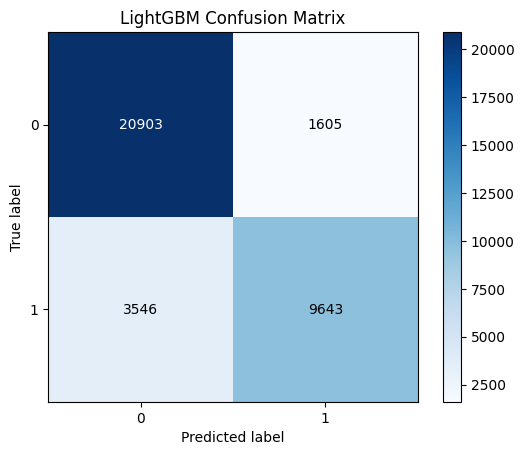



RandomForest Test F1: 0.8194821508164837
RandomForest Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     22508
           1       0.88      0.77      0.82     13189

    accuracy                           0.88     35697
   macro avg       0.88      0.85      0.86     35697
weighted avg       0.88      0.88      0.87     35697



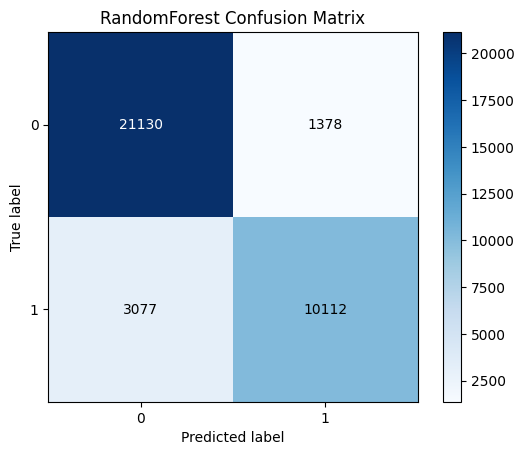



LogisticRegression Test F1: 0.7022400136274595
LogisticRegression Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.85     22508
           1       0.80      0.63      0.70     13189

    accuracy                           0.80     35697
   macro avg       0.80      0.77      0.78     35697
weighted avg       0.80      0.80      0.80     35697



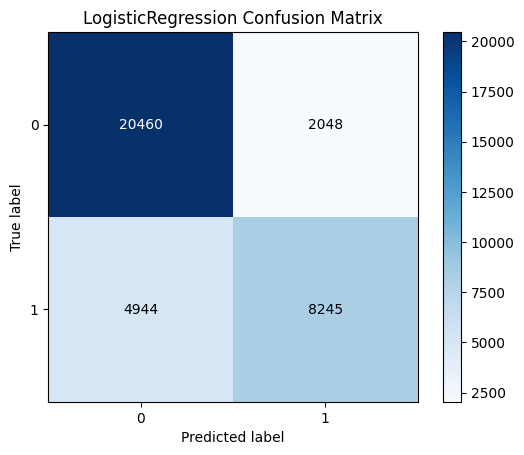



SVM Test F1: 0.7808475957620212
SVM Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     22508
           1       0.84      0.73      0.78     13189

    accuracy                           0.85     35697
   macro avg       0.85      0.82      0.83     35697
weighted avg       0.85      0.85      0.85     35697



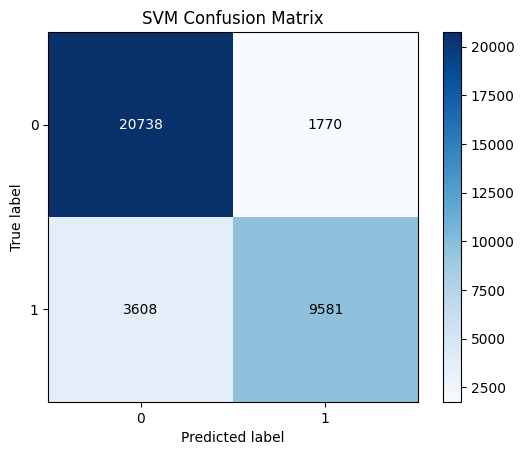

In [136]:
for model, name in zip(model_list, model_name_list):
    y_test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"{name} Test F1: {test_f1}")
    print(f"{name} Test Classification Report:\n{classification_report(y_test, y_test_pred)}")

    skplt.metrics.plot_confusion_matrix(y_test, y_test_pred, title=f"{name} Confusion Matrix")
    plt.show()
    print("\n")

### Overfitting insight

Hasil metric tidak menunjukkan tanda-tanda overfitting. Performa pada validation set dan test set sangat mirip, menunjukkan bahwa model memiliki performa yang baik pada data yang belum pernah dilihat sebelumnya (test data)

## Hyperparameter Tuning

Dari hasil metric yang didapat pada pengetesan Validation Data, dapat disimpulkan bahwa model `Random Forest` merupakan model yang terbaik untuk digunakan pada dataset ini.

In [137]:
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
}

rf_model_tuned = RandomForestClassifier(random_state=42)

In [138]:
# random_search = RandomizedSearchCV(estimator=rf_model_tuned, param_distributions=param_dist, n_iter=5, cv=5, scoring='f1', n_jobs=-1, random_state=42)
# random_search.fit(X_train, y_train)

# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation accuracy: ", random_search.best_score_)

In [139]:
random_search = RandomizedSearchCV(estimator=rf_model_tuned, param_distributions=param_dist, n_iter=5, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: ", random_search.best_score_)

Best parameters found:  {'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 17, 'min_samples_split': 11, 'n_estimators': 287}
Best cross-validation accuracy:  0.8063552373548634


### Result on Train Data

In [140]:
best_model = random_search.best_estimator_

y_train_pred = best_model.predict(X_train)
print("Train F1: ", f1_score(y_train, y_train_pred))
print("Classification Report: \n", classification_report(y_train, y_train_pred))

Train F1:  0.8287023962112489
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91     42044
           1       0.89      0.78      0.83     24590

    accuracy                           0.88     66634
   macro avg       0.88      0.86      0.87     66634
weighted avg       0.88      0.88      0.88     66634



### Result on Validation Data

In [141]:
# y_val_pred = best_model.predict(X_val)
# print("Validation F1: ", f1_score(y_val, y_val_pred))
# print("Classification Report: \n", classification_report(y_val, y_val_pred))

### Result on Test Data

In [142]:
y_test_pred = best_model.predict(X_test)
print("Random Forest Test F1: ", f1_score(y_test, y_test_pred))
print("Random Forest Test Classification Report: \n", classification_report(y_test, y_test_pred))

Random Forest Test F1:  0.7948345305817381
Random Forest Test Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     22508
           1       0.88      0.73      0.79     13189

    accuracy                           0.86     35697
   macro avg       0.87      0.83      0.85     35697
weighted avg       0.86      0.86      0.86     35697



## Best Model Result

Observation:

Ternyata Randomized Search tidak berhasil mendapatkan parameter yang lebih baik untuk mengalahkan performa model awal.

Maka kita akan gunakan model awal

### Classification Report

In [145]:
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)
print("Random Forest Test F1: ", f1_score(y_test, y_test_pred))
print("Random Forest Test Classification Report: \n", classification_report(y_test, y_test_pred))

Random Forest Test F1:  0.7948345305817381
Random Forest Test Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     22508
           1       0.88      0.73      0.79     13189

    accuracy                           0.86     35697
   macro avg       0.87      0.83      0.85     35697
weighted avg       0.86      0.86      0.86     35697



**Confusion Matrix**

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

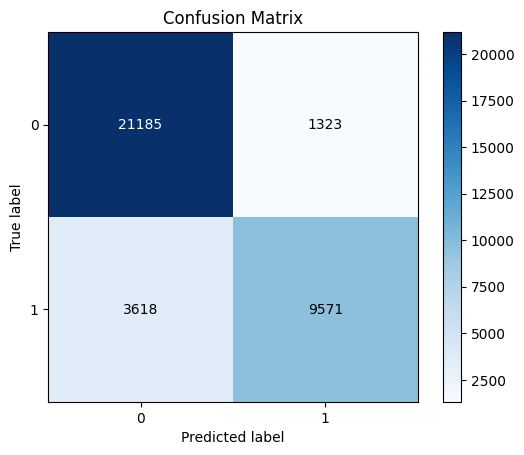

In [146]:
skplt.metrics.plot_confusion_matrix(y_test, y_test_pred)

**ROC-AUC**

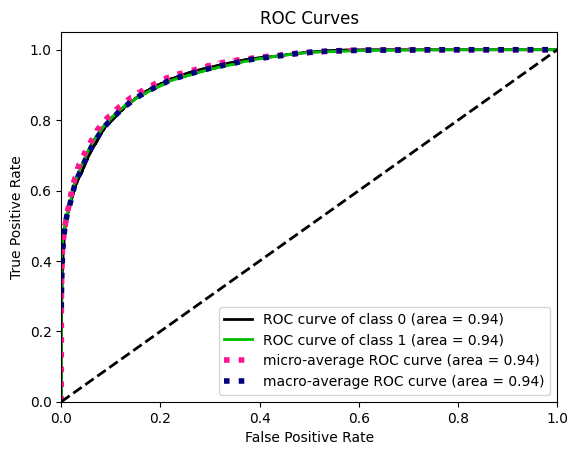

In [147]:
skplt.metrics.plot_roc_curve(y_test, y_test_pred_proba);

# Feature Importance

In [148]:
rf_model_explainer = dx.Explainer(best_model, X_train, y_train, label = "Random Forest Interpretation")

Preparation of a new explainer is initiated

  -> data              : 66634 rows 26 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 66634 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Interpretation
  -> predict function  : <function yhat_proba_default at 0x7fa866894f70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.4e-05, mean = 0.369, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.848, mean = -0.00029, max = 0.942
  -> model_info        : package sklearn

A new explainer has been created!


In [149]:
np.random.seed(42)
rf_model_explainer.model_parts().plot()

In [150]:
rf_model_explainer.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 26/26 [00:20<00:00,  1.24it/s]


Observations:

Berdasarkan feature importance dari model Random Forest, berikut adalah 5 feature yang berpengaruh penting terhadap keputusan model:

1. `pct_country`

`pct_country` menempati posisi paling atas bagi feature importance model. Hal ini menunjukkan pengaruh besar dari persentase negara asal tamu terhadap kemungkinan pembatalan reservasi. Tamu dari negara tertentu mungkin memiliki kecenderungan yang lebih tinggi untuk membatalkan reservasi.

Business recommendations:
- Pertimbangkan untuk meminta deposit atau menerapkan kebijakan pembatalan yang lebih ketat untuk tamu dari negara tingkat pembatalan tinggi (Seperti Portugal)
- Tawarkan fleksibilitas pembatalan khusus untuk jauh hari, dan penalti untuk yang mepet.

2. `pct_market_segment`

Segmentasi pasar memiliki pengaruh terhadap feature importance model.

Business recommendations:
- Menerapkan kebijakan deposit atau menerapkan kebijakan pembatalan yang lebih ketat, terutama bagi market segment yang rasio pembatalannya tinggi
- Mendorong pelanggan untuk memesan secara langsung (Direct). Bisa dengan menawarkan promosi eksklusif atau loyalty program.

3. `total_of_special_requests`

Jumlah special request yang diajukan oleh tamu saat reservasi dapat mempengaruhi kemungkinan pembatalan. Menurut insight saya, mungking tamu dengan banyak special request cenderung lebih berkomitmen terhadap pesanannya. Dari plot juga membuktikan bahwa semakin tinggi special request, maka ada kecenderungan penurunan kemungkinan pembatalan.

Business recommendations:
- Perusahaan dapat mengakomodasi special request tamu dengan lebih baik untuk mengurangi kemungkinan pembatalan, dan diinfokan di advertisement. Ini bisa mencakup mengiklankan bahwa perusahaan menerima opsi special request banyak dan memastikan bahwa permintaan tersebut dapat dipenuhi, sehingga pemesan yang memesan lebih mempertimbangkan special request dan lebih commit terhadap pesanannya.

4. `lead_time`

Lead time atau range tanggal pemesanan dan tanggal kedatangan juga berpengaruh besar. Jika dilihat dari plot, pemesanan dengan lead time yang makin panjang memiliki kemungkinan untuk melakukan pembatalan yang meningkat.

Business recommendations:
- Perusahaan dapat mempertimbangkan kebijakan pembayaran di muka atau deposit untuk pemesanan yang dilakukan jauh hari sebelumnya. Selain itu, bisa juga dengan menawarkan diskon atau insentif untuk pemesanan yang dilakukan dalam waktu dekat dengan tanggal kedatangan untuk mengurangi risiko pembatalan.

5. `pct_agent`

Agent yang digunakan untuk melakukan reservasi juga mempengaruhi kemungkinan pembatalan. Beberapa Agent memiliki tingkat pembatalan yang lebih tinggi dibandingkan yang lain.

Business recommendation:
- Karena ini di luar ranah perusahaan, perusahaan bisa mengidentifikasi Agent yang memiliki tingkat pembatalan tinggi, lalu berkolaborasi dengan Agent tersebut untuk memahami penyebab pembatalan dan mencari solusi untuk menguranginya.
- Menawarkan insentif kepada Agent untuk mengurangi pembatalan mungkin dapat membantu mengurangi tingkat pembatalan.